# Model Similarity Demo


This toy demo utilizes the **Tikos Python package** to compare four deep-learning models on a classification task using the iris dataset.

**Key Differentiator:** The models are identical except for the number of neurons in their single hidden layer:

- Model 1: 10 neurons
- Model 2: 20 neurons
- Model 3: 50 neurons
- Model 4: 500 neurons

For a non-technical overview of Tikos' features and applications, please see this article:
[[Link to Medium Article](https://medium.com/tikos-tech/tikos-spots-neural-network-weaknesses-before-they-fail-the-iris-dataset-b079265c04da)]

#### Core Functionality: `process_embedded_model`

The central function in this demonstration is `process_embedded_model`. This function performs a detailed computation at the neuron level during inference, analyzing inputs, weights, and activations. This proprietary process is called **'Synapses Logger'**.

The outputs from the Synapses Logger are then stored in a proprietary data structure known as a **'Sequential Collection'**.

#### Output & Analysis Capabilities

The raw data generated by the **Synapses Logger** and stored in the **Sequential Collection** serves as a rich resource for various analytical tasks, including:

- Model debugging
- Feature evaluations
- Stress-testing
- Generating aggregated reports for compliance teams
- Addressing end-user queries

#### Example Findings from This Demo

In this specific example, the analysis of causality trace variance reveals the following insights:

- **Robustness:** All four models are likely to be robust and reliable for classifying species 1 & 2 on unseen data.
- **Brittleness:** However, all models exhibit brittleness when classifying species 0 and may face challenges or breakdowns in a production environment for this class.

#### Demo Conclusion & Reporting

The demonstration concludes with:

1.  **Standard Reports:** Individual performance reports for each of the four models.
2.  **Comparison Report:** A consolidated report recommending the optimal model based on:
    - Accuracy
    - Causality trace variance
    - Execution time
    - Model size (complexity)
3.  **Extended Analysis:** Performance evaluation across 4 modified datasets to further test model behavior.

#### Important Note (N.B.)

The functions `upload_context` and `create_graph` include capabilities that are part of the broader Tikos pipeline but are **not actively used in this particular demo**.

These advanced features, focused on **reasoning and explainability**, will be showcased in subsequent demonstrations.

For detailed technical information, please refer to the **Tikos technical documentation**:
[https://tikos.readme.io/](https://tikos.readme.io/)


In [56]:
import requests
import datetime
import json
import csv
from tikos.client.TikosClient import TikosClient
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import io
from matplotlib.patches import Patch
import time
import random
import ast
from IPython.display import display, Markdown
import os
import math
import tabulate

In [57]:
contextfilepath = "../model_comparison/data_Folder/iris.txt"
traindatafilepath = "../model_comparison/iris.1.csv"
testdatafilepath = "../model_comparison/data_Folder/iris_test.csv"

### Sends an extraction request to the API and processes the response.


In [58]:
def create_request(orgid, orgtoken, userid, num_of_files):
    """
    Sends an extraction request to the API and processes the response.
    """
    rtn_bool = False
    extracted_request_id = None
    extracted_auth_token = None
    start = datetime.datetime.now()
    print("--- Sending Extraction Request ---")
    try:
        r = requests.post(
            "https://api.tikos.tech/client/extractionrequest",
            json={
                "orgId": orgid,
                "token": orgtoken,
                "userId": userid,
                "numOfFiles": num_of_files,
            },
            timeout=10,
        )

        end = datetime.datetime.now()
        print(f"Request duration: {end - start}")
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++")
        print(f"Status Code: {r.status_code}, Reason: {r.reason}")

        if r.status_code == 200:
            try:
                response_data = r.json()
                extracted_request_id = response_data.get("requestId")
                extracted_auth_token = response_data.get("authToken")
                print("extracted_request_id",extracted_request_id)
                print("extracted_auth_token", extracted_auth_token)

                if extracted_request_id and extracted_auth_token:
                    rtn_bool = True
                else:
                    print("Error: requestId or authToken missing/null.")
            except requests.exceptions.JSONDecodeError:
                print("Error: Failed to decode JSON response.")
                print("Response Text:", r.text)
        else:
            print(f"Error: Request failed. Status Code: {r.status_code}")
            print("Response Text:", r.text)

    except requests.exceptions.Timeout:
        print("Error: The request timed out.")
    except requests.exceptions.RequestException as e:
        print(f"Error: An error occurred during the request: {e}")

    
    return rtn_bool, extracted_request_id, extracted_auth_token

### Uploads and processes the context file


In [ ]:
def upload_context(tikos_client_obj):
    """Uploads the context file."""
    
    try:
        context_name = os.path.basename(contextfilepath)
        
        print("--- Uploading and Processing Context ---")
        with open(contextfilepath, "rb") as iris_context:
            rtnval_files_context = tikos_client_obj.addProcessFileStreams([(context_name, iris_context)])

        print("Uploading and Processing Context, Complete.")

        unpacked_results = [future.result() for future in rtnval_files_context]
        print(unpacked_results)

        fn, rtn_val_add, rtnval_process = unpacked_results[0]
        print(rtn_val_add)
        print(rtnval_process)
        
        return True

    except requests.exceptions.RequestException as e:
        return False, f"An error occurred: {e}"
    except Exception as e:
        return False, f"An unexpected error occurred: {e}"

### Generates and creates graphs.


In [ ]:
def create_graph(tikos_client_obj):
    """Generates and creates graphs."""
    print("--- Generating and Creating Graphs. ---")
    try:
        context_name = os.path.basename(contextfilepath)
        print(context_name)
        # Get Graph Structure
        rtnval_get_graph_struct = tikos_client_obj.generateGraphStructures(contexts=[context_name])
        graph_results = [future.result() for future in rtnval_get_graph_struct]

        print(graph_results)
        fn, rtnval = graph_results[0]
        print(rtnval)
        t_rtncode, t_msg, t_rtnval = rtnval

        print(t_rtnval)
        json_response = json.loads(t_rtnval)
        json_llm_response = str(json_response.get("llmExtraction"))
        print(json_llm_response)

        print("Get Graph Structure, Complete.")

        # Generate Graph Structure
        rtnval_gen_graph_struct = tikos_client_obj.createGraph(contexts=[context_name])
        create_graph_results = [future.result() for future in rtnval_gen_graph_struct]
        print("Generate Graph Structure, Complete.")
        
        return True, graph_results, create_graph_results

    except Exception as e:
        return False, f"An error occurred: {e}"

### Uploads an embedding model.


In [61]:
def upload_embedding_model(tikos_client_obj, model_path):
    """Uploads an embedding model."""
    try:
        # Extract just the filename from the model_path
        model_name = os.path.basename(model_path)
        with open(model_path, "rb") as model_file:
            # Use the extracted model_name here
            model_obj = (model_name, model_file)
            rtn_val = tikos_client_obj.uploadEmbeddingModel(modelObj=model_obj)
            rtn_status_code, rtn_reason, rtn_text = rtn_val
            print("Upload Embedding Model:", rtn_text)
            
            return rtn_val
    except Exception as e:
        print(f"Error uploading embedding model: {e}")
        return None

### Uploads embedding configuration.


In [62]:
def upload_embedding_config(tikos_client_obj, config_path, schema_path):
    """Uploads embedding configuration."""
    try:
        # Extract just the filenames
        config_name = os.path.basename(config_path)
        schema_name = os.path.basename(schema_path)

        with open(config_path, "rb") as config_file, open(schema_path, "rb") as schema_file:
            # Use the extracted filenames here
            model_config = (config_name, config_file)
            model_schema = (schema_name, schema_file)

            rtn_val = tikos_client_obj.uploadEmbeddingConfig(
                modelConfig=model_config, modelSchema=model_schema
            )
            print("Upload Embedding Config:", rtn_val)
            return rtn_val
    except Exception as e:
        print(f"Error uploading embedding configuration: {e}")
        return None

### Uploads model case data.


In [63]:
def upload_model_case_data(tikos_client_obj, data_path):
    """Uploads model case data."""
    try:
        # Extract just the filename from the data_path
        data_file_name = os.path.basename(data_path)

        with open(data_path, "rb") as data_file:
            # Use the extracted data_file_name here
            case_data_set = (data_file_name, data_file)
            rtn_val = tikos_client_obj.uploadModelCaseData(caseDataSet=case_data_set)
            print("Upload Model Case Data:", rtn_val)
            return rtn_val
    except Exception as e:
        print(f"Error uploading model case data: {e}")
        return None

### Processes an embedded model to create a Sequential Collection (SC).


In [64]:
def process_embedded_model(tikos_client_obj, case_type):
    """Processes an embedded model to create a Sequential Collection (SC)."""
    try:
        rtn_val = tikos_client_obj.processEmbeddedModel(caseType=case_type)
        print("Process Embedded Model:", rtn_val)
        return rtn_val
    except Exception as e:
        print(f"Error processing embedded model: {e}")
        return None

### Prints reasoning status of the model

(Padding with NaN: This is a crucial step for handling inconsistent lengths.)


In [65]:
def calculate_average_trace(traces):
    """
    Calculates the element-wise average of traces, handling inconsistent lengths
    by padding with NaN. Returns None if traces list is empty or malformed.
    """
    if not traces:
        return None

    try:
        # Find the maximum length of any trace in the list
        max_len = 0
        for trace in traces:
             # Basic check if trace is a list/tuple before getting len
            if hasattr(trace, '__len__'):
                max_len = max(max_len, len(trace))
            else:
                # Handle case where an item in 'traces' is not a list/sequence
                print(f"Warning: Non-list item found in traces: {trace}")
                return None # Cannot proceed if data is malformed

        if max_len == 0: # All traces were empty or invalid
             return None

        padded_traces = []
        for trace in traces:
            # Ensure trace is a list before padding
            if isinstance(trace, (list, tuple)):
                # Create a copy to avoid modifying original data
                padded_trace = list(trace)
                # Pad with np.nan
                padding_needed = max_len - len(padded_trace)
                padded_trace.extend([np.nan] * padding_needed)
                padded_traces.append(padded_trace)
            # else: skip non-list items already handled by print above

        if not padded_traces: # No valid traces were found after filtering
            return None

        # Convert the padded list of lists to a NumPy array
        traces_array = np.array(padded_traces, dtype=float) # Ensure float dtype for NaN

        # Calculate the mean, ignoring NaNs
        average = np.nanmean(traces_array, axis=0)
        # print("================average",average)
        average_list = average.tolist()
        # print("================average_list",average_list)
        return average_list

    except Exception as e:
        # Catch any other unexpected errors during processing
        print(f"Error during averaging: {e}")
        return None

In [66]:
def get_reasoning_status(tikos_client_obj,model_id_str, case_type):
    
    context_name = os.path.basename(traindatafilepath)
    data = []

    # Open a csv reader called DictReader
    with open(testdatafilepath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)

        # and add it to data
        for rows in csvReader:
            strTemplate = """{"sepal_length": @sepal_length, "sepal_width": @sepal_width, "petal_length": @petal_length, "petal_width": @petal_width, "species": "@species"}"""
            strVal = strTemplate.replace("@sepal_length", rows['sepal_length']).replace("@sepal_width",
                                                                                        rows['sepal_width']).replace(
                "@petal_length", rows['petal_length']).replace("@petal_width", rows['petal_width']).replace("@species",
                                                                                                            rows[
                                                                                                                'species'])
            print("strVal : ",strVal)
            data.append(strVal)

    s_count = 0
    correct_count = 0
    incorrect_count = 0
    response_count = 0
    
    target_species_ids = {0, 1, 2} # Assuming species are encoded as 0, 1, 2 in CSV/logic

    # --- Step 2: Collect ALL Results Per Species ---
    temp_equal_results = {}
    temp_unequal_results = {}

    for ps_c in data:
        s_count += 1
        # print(f"\n--- Processing case {s_count} ---")
        print(f"\n\nInput case JSON(ps_c): {ps_c}")

        try:
            # Call the API
            rtnval_reasoning = tikos_client_obj.generateReasoning(
                caseType= case_type, context= context_name, problemSpaceCase=ps_c, rType="DEEPCAUSAL"
            )
            rcode, rmsg, rpayload = rtnval_reasoning

            if rcode == 200:
                response_count += 1
                jpayload = json.loads(rpayload)
                jps_c = json.loads(ps_c) # Parse the input case JSON

                # Safely extract values
                psv_str = jps_c.get('species')
                print("psv_str---",psv_str)
                ssv_list = jpayload.get('scCaseSim', {}).get('SSFeaturesBase', [])
                causality_trace = jpayload.get('scCaseSim', {}).get('CausalityTrace', [])
                
                print("rpayload" , rpayload)



                print("PS VAL Base:{}".format(jpayload['scCaseSim']['PSFeaturesBase']))
                print("SS VAL Base:{}".format(jpayload['scCaseSim']['SSFeaturesBase']))
                
                print("PS VAL:{}".format(jpayload['scCaseSim']['PSFeatures']))
                print("SS VAL:{}".format(jpayload['scCaseSim']['SSFeatures']))

                if psv_str is None:
                    print(f"Warning: 'species' key missing in input case: {ps_c}")
                    continue # Skip this case

                # Assuming species is the 5th element (index 4) in SSFeaturesBase
                if len(ssv_list) > 4:
                    ssv_str = str(ssv_list[4])
                    print("ssv_str---",ssv_str)
                    # Ensure string comparison
                else:
                    print(f"Warning: SSFeaturesBase has < 5 elements in response for case: {ps_c}")
                    continue # Skip if output species is missing

                # Assuming species can be converted to int for dict key
                try:
                    psv_int = int(psv_str)
                except ValueError:
                    print(f"Warning: Cannot convert input species '{psv_str}' to int for case: {ps_c}")
                    continue # Skip if species ID is not valid integer

                print(f"Case {s_count}: Input Species={psv_str}, Output Species={ssv_str}")

                # Ensure CausalityTrace exists and has at least 4 items
                if len(causality_trace) > 3:
                    fourth_causality_trace_item = causality_trace[3]

                    # Check if prediction is correct
                    if ssv_str == psv_str:
                        correct_count += 1
                        # Add the trace to the list for this species_id
                        if psv_int in target_species_ids:
                            temp_equal_results.setdefault(psv_int, []).append(fourth_causality_trace_item)
                            # print(f"  Collected EQUAL trace for species {psv_int}") # Debug print
                    else:
                        incorrect_count += 1
                        # Add the trace to the list for this species_id
                        if psv_int in target_species_ids:
                            temp_unequal_results.setdefault(psv_int, []).append(fourth_causality_trace_item)
                            # print(f"  Collected UNEQUAL trace for species {psv_int}") # Debug print
                else:
                     print(f"Warning: CausalityTrace has < 4 items in response for case: {ps_c}")

            else:
                print(f"API call failed for case {s_count} (Input: {ps_c}) with code {rcode}: {rmsg}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for case {s_count} (Input: {ps_c}). Error: {e}")
            print(f"Payload received: {rpayload}")
        except (KeyError, IndexError) as e:
            print(f"Error processing payload structure for case {s_count} (Input: {ps_c}). Error: {e}")
        except Exception as e: # Catch other potential errors during processing
             print(f"An unexpected error occurred processing case {s_count} (Input: {ps_c}). Error: {e}")


    # --- Step 3: Randomly Select One Result Per Species ---
    print("temp_equal_results",temp_equal_results)
    print("temp_unequal_results",temp_unequal_results)
    print("\n--- Randomly Selecting Final Causality Traces ---")
    equal_causality_results = {}
    unequal_causality_results = {}
    
    qoute_reasoned = []

    for species_id in target_species_ids:
        # --- Process EQUAL results ---
        if species_id in temp_equal_results and temp_equal_results[species_id]:
            # Get the list of traces collected for this species ID
            collected_traces = temp_equal_results[species_id]
            # Randomly choose one trace from the list
            selected_item = random.choice(collected_traces)
            equal_causality_results[species_id] = selected_item
            print(f"Selected EQUAL trace for species {species_id}: {selected_item} (from {len(collected_traces)} options)")
        else:
            quote = f"All cases for species {species_id}  is incorrectly reasoned."
            qoute_reasoned.append(quote)
            print(f"{model_id_str}: All cases for species {species_id}  is incorrectly reasoned.")

        # --- Process UNEQUAL results ---
        if species_id in temp_unequal_results and temp_unequal_results[species_id]:
            # Get the list of traces collected for this species ID
            collected_traces = temp_unequal_results[species_id]
            # Randomly choose one trace from the list
            selected_item = random.choice(collected_traces)
            unequal_causality_results[species_id] = selected_item
            print(f"Selected UNEQUAL trace for species {species_id}: {selected_item} (from {len(collected_traces)} options)")
        else:
            quote = f"All cases for species {species_id}  is correctly reasoned."
            qoute_reasoned.append(quote)
            print(f"{model_id_str}: All cases for species {species_id}  is correctly reasoned.")
     
 
    # --- Step 4: Average One Result Per Species ---
    equal_causality_averages = {}
    unequal_causality_averages = {}
            

    equal_average_trace_stats = {}
    unequal_average_trace_stats = {}

    for species_id in target_species_ids:
        # --- Process EQUAL results ---
        if species_id in temp_equal_results and temp_equal_results[species_id]:
            collected_traces = temp_equal_results[species_id]
            count = len(collected_traces)
            average_trace = calculate_average_trace(collected_traces)

            if average_trace is not None:
                equal_causality_averages[species_id] = average_trace # Optional storage

                q1, q3, iqr = np.nan, np.nan, np.nan
                try:
                    trace_array = np.asarray(average_trace)
                    finite_trace = trace_array[np.isfinite(trace_array)]
                    if finite_trace.size >= 2:
                        q1_np, q3_np = np.percentile(finite_trace, [25, 75])
                        q1 = float(q1_np)
                        q3 = float(q3_np)
                        iqr = q3 - q1
                    else:
                        # Optional print: print(f"Warning: Not enough finite data points...")
                        pass # Keep defaults as NaN

                except Exception as e:
                    print(f"Error calculating stats for EQUAL average trace for species {species_id}: {e}")

                # Store the calculated stats in the 'Equal' dictionary
                equal_average_trace_stats[species_id] = {
                    'Min point': q1,
                    'Max point': q3,
                    'Variance': iqr # Storing the difference Q3-Q1 as IQR
                }
            
            

        # --- Process UNEQUAL results ---
        if species_id in temp_unequal_results and temp_unequal_results[species_id]:
            collected_traces = temp_unequal_results[species_id]
            count = len(collected_traces)
            average_trace = calculate_average_trace(collected_traces)

            if average_trace is not None:
                unequal_causality_averages[species_id] = average_trace # Optional storage

                q1, q3, iqr = np.nan, np.nan, np.nan
                try:
                    trace_array = np.asarray(average_trace)
                    finite_trace = trace_array[np.isfinite(trace_array)]
                    if finite_trace.size >= 2:
                        q1_np, q3_np = np.percentile(finite_trace, [25, 75])
                        q1 = float(q1_np)
                        q3 = float(q3_np)
                        iqr = q3 - q1
                    else:
                        # Optional print: print(f"Warning: Not enough finite data points...")
                        pass # Keep defaults as NaN

                except Exception as e:
                    print(f"Error calculating stats for UNEQUAL average trace for species {species_id}: {e}")

                # Store the calculated stats in the 'Unequal' dictionary
                unequal_average_trace_stats[species_id] = {
                    'Min point': q1,
                    'Max point': q3,
                    'Variance': iqr # Storing the difference Q3-Q1 as IQR
                }
           

    
    
    # --- Step 4: Return Final Results ---
    print("\n--- Final Selected Results ---")
    print("\n** Final Equal Results :", equal_causality_results)
    print("\n** Final Unequal Results :", unequal_causality_results)
    
    
   # --- Final Results ---
    print("\n--- Final Calculated Averages ---")
    print("\n** Equal Causality Averages:",equal_causality_averages)
    

    print("\n** Unequal Causality Averages:",unequal_causality_averages)
    
    
    print("\n--- variance for average causilty results ---")
    print("\n** Equal average trace :", equal_average_trace_stats)
    print("\n** Unequal average trace :", unequal_average_trace_stats)
    
    
    
    return {
        "correct_count": correct_count,
        "incorrect_count": incorrect_count,
        "total_count": s_count,
        "response_count": response_count,
        "equal_causality_results": equal_causality_results,   # Contains ONE randomly selected trace per species (if available)
        "unequal_causality_results": unequal_causality_results, # Contains ONE randomly selected trace per species (if available)
        "equal_causality_averages": equal_causality_averages,
        "unequal_causality_averages":unequal_causality_averages,
        "equal_average_trace_stats": equal_average_trace_stats,
        "unequal_average_trace_stats": unequal_average_trace_stats,
        "qoute_reasoned":qoute_reasoned,    
    }
 

### Visualizations of performance of reasoning Causality Trace of models


#### Selects one random instance for each of species 0, 1, and 2 found, generates reasoning for them, and extracts the 4th item from the CausalityTrace


In [67]:
def get_reasoning_trace(tikos_client_obj , case_type):
    """
    Reads an Iris dataset CSV, selects ONE RANDOM instance for each of
    species 0, 1, and 2 found, generates reasoning for them, and
    extracts the 4th item from the CausalityTrace.
    """
    # Dictionary to store all found instances for each target species
    candidate_rows_by_species = {"0": [], "1": [], "2": []}

    # --- Phase 1: Read the CSV and collect all candidate rows ---
    print(f"Reading candidates from: {testdatafilepath}")
    context_name = os.path.basename(traindatafilepath)
    rows_processed = 0
    try:
        # Open the csv file
        with open(testdatafilepath, encoding='utf-8') as csvf:
            csvReader = csv.DictReader(csvf)

            # Iterate over rows and collect candidates
            for rows in csvReader:
                rows_processed += 1
                current_species = rows.get('species')

                # Check if the species is one we are interested in
                if current_species in candidate_rows_by_species:
                    strTemplate = """{"sepal_length": @sepal_length, "sepal_width": @sepal_width, "petal_length": @petal_length, "petal_width": @petal_width, "species": "@species"}"""
                    try:
                        # Create the JSON-like string representation
                        strVal = strTemplate.replace("@sepal_length", rows['sepal_length']) \
                                            .replace("@sepal_width", rows['sepal_width']) \
                                            .replace("@petal_length", rows['petal_length']) \
                                            .replace("@petal_width", rows['petal_width']) \
                                            .replace("@species", rows['species'])

                        # Add the formatted string to the list for the current species
                        candidate_rows_by_species[current_species].append(strVal)

                    except KeyError as e:
                        print(f"Warning: Row {rows_processed} missing expected column {e}. Skipping row: {rows}")
                    except Exception as e_inner:
                        print(f"Warning: Error processing row {rows_processed} ({rows}). Error: {e_inner}. Skipping row.")

    except FileNotFoundError:
        print(f"Error: CSV file not found at {testdatafilepath}")
        return {} # Return empty if file not found
    except Exception as e_outer:
        print(f"Error reading CSV file {testdatafilepath}: {e_outer}")
        return {} # Return empty on other file errors

    print(f"Finished reading {rows_processed} rows.")
    for sp, candidates in candidate_rows_by_species.items():
        print(f"Found {len(candidates)} candidate(s) for species {sp}.")

    # --- Phase 2: Randomly select one instance per species (if available) ---
    filtered_data = [] # This list will store the randomly selected instances
    print("\nSelecting random instance for each target species...")

    for species_key, candidates in candidate_rows_by_species.items():
        if candidates: # Check if we found any candidates for this species
            selected_instance = random.choice(candidates) # Select one randomly
            filtered_data.append(selected_instance)
            print(f"Selected for species {species_key}: {selected_instance}")
        else:
            print(f"Warning: No candidates found for species {species_key}. Skipping.")

    # --- Phase 3: Process the selected instances ---
    causality_results_by_species = {}
    s_count = 0
    print("\nGenerating reasoning for selected instances...")

    for ps_c in filtered_data: # Iterate through the randomly selected instances
        s_count += 1
        print(f"\nProcessing selected instance {s_count}: {ps_c}")

        current_species = None
        ps_c_dict = None

        try:
            # Load the string as JSON to extract the species easily
            ps_c_dict = json.loads(ps_c)
            current_species = ps_c_dict.get('species') # Should always be present if formatting was correct
            if current_species is None:
                 print(f"Warning: Could not extract species from {ps_c}. Skipping API call.")
                 continue
            print(f"Extracted Species: {current_species}")

            # Generate reasoning using the tikos client
            rtnval_reasoning = tikos_client_obj.generateReasoning(
                caseType= case_type, context= context_name, problemSpaceCase=ps_c, rType="DEEPCAUSAL"
            )
            rcode, rmsg, rpayload = rtnval_reasoning
            # print("rcode", rcode)
            # print("rmsg", rmsg)
            print("API Response Payload (rpayload):", rpayload) # Log the raw payload for debugging

            # Extract the 4th item from CausalityTrace
            fourth_causality_trace_item = None
            jpayload = json.loads(rpayload) # Parse the API response payload

            # Navigate safely, checking keys exist
            if 'scCaseSim' in jpayload and isinstance(jpayload['scCaseSim'], dict) and \
               'CausalityTrace' in jpayload['scCaseSim'] and \
               isinstance(jpayload['scCaseSim']['CausalityTrace'], list) and \
               len(jpayload['scCaseSim']['CausalityTrace']) > 3:

                fourth_causality_trace_item = jpayload['scCaseSim']['CausalityTrace'][3]
                causality_results_by_species[current_species] = fourth_causality_trace_item
                print(f"Stored 4th CausalityTrace item for species {current_species}: {fourth_causality_trace_item}")

            else:
                 # Provide more specific feedback if the structure is missing
                 if 'scCaseSim' not in jpayload:
                      print(f"Error: Key 'scCaseSim' not found in payload for species {current_species}.")
                 elif 'CausalityTrace' not in jpayload.get('scCaseSim', {}):
                      print(f"Error: Key 'CausalityTrace' not found in 'scCaseSim' for species {current_species}.")
                 elif not isinstance(jpayload.get('scCaseSim', {}).get('CausalityTrace'), list):
                      print(f"Error: 'CausalityTrace' is not a list for species {current_species}.")
                 elif len(jpayload.get('scCaseSim', {}).get('CausalityTrace', [])) <= 3:
                      trace_len = len(jpayload.get('scCaseSim', {}).get('CausalityTrace', []))
                      print(f"Error: 'CausalityTrace' has only {trace_len} items (need index 3) for species {current_species}.")

            print("-" * 60) # Separator for clarity

        except json.JSONDecodeError as e:
             print(f"Error: Failed to decode JSON from input string '{ps_c}' or API response '{rpayload}'. Details: {e}")
        except KeyError as e:
            # This might catch issues during the safe navigation if not careful, though less likely now
            print(f"Error: Key {e} not found unexpectedly during payload processing for species {current_species}.")
        except TypeError as e:
            print(f"Error: Problem accessing data, possibly incorrect structure or type: {e} for species {current_species}")
        except Exception as e:
            # Catch other potential errors during API call or processing
            print(f"An unexpected error occurred processing species {current_species}: {e}")

    print("\nFinished processing.")
    return causality_results_by_species

#### Generates a grouped bar plot comparing the 'correct' and 'incorrect' reasoning counts from four model result dictionaries.


In [68]:
def plotting_model_results(model1_results, model2_results, model3_results, model4_results):
    """
    Generates a grouped bar plot comparing the 'correct' and 'incorrect'
    counts from four model result dictionaries.

    """
    data_to_plot = []
    # Initialize fig and ax outside try block for consistent return signature
    fig, ax = None, None

    try:
        print("--- Prepare data for plotting ---")
        # Add data for the first model
        data_to_plot.append({'Model': 'Model 1', 'Metric': 'Correct', 'Count': model1_results['correct_count']})
        data_to_plot.append({'Model': 'Model 1', 'Metric': 'Incorrect', 'Count': model1_results['incorrect_count']})

        # Add data for the second model
        data_to_plot.append({'Model': 'Model 2', 'Metric': 'Correct', 'Count': model2_results['correct_count']})
        data_to_plot.append({'Model': 'Model 2', 'Metric': 'Incorrect', 'Count': model2_results['incorrect_count']})

        # Add data for the third model
        data_to_plot.append({'Model': 'Model 3', 'Metric': 'Correct', 'Count': model3_results['correct_count']})
        data_to_plot.append({'Model': 'Model 3', 'Metric': 'Incorrect', 'Count': model3_results['incorrect_count']})

        # Add data for the fourth model
        data_to_plot.append({'Model': 'Model 4', 'Metric': 'Correct', 'Count': model4_results['correct_count']})
        data_to_plot.append({'Model': 'Model 4', 'Metric': 'Incorrect', 'Count': model4_results['incorrect_count']})


        # Create a Pandas DataFrame
        df = pd.DataFrame(data_to_plot)

        # --- Create the plot ---
        # Initialize the figure and axes explicitly
        # Increase figure width slightly to accommodate more bars
        fig, ax = plt.subplots(figsize=(10, 7))

        # Create the grouped bar plot using Seaborn, passing the axes object
        # Seaborn automatically handles grouping by 'hue' for the additional models
        sns.barplot(x='Metric', y='Count', hue='Model', data=df, palette='pastel', ax=ax)

        # Add labels on top of the bars for clarity
        # '%d' formats the label as an integer
        for container in ax.containers:
            # Adjust label formatting if counts can be large or non-integer
            ax.bar_label(container, fmt='%d', padding=3) # Add padding

        # Add titles and labels using the axes object
        ax.set_title('Comparison of Reasoning Status for Four Models', fontsize=16)
        ax.set_xlabel('Status Metric', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
        ax.tick_params(axis='x', labelsize=10) # Set x-tick parameters via ax
        ax.tick_params(axis='y', labelsize=10) # Set y-tick parameters via ax

        # Improve layout using the figure object
        # Use bbox_inches='tight' to potentially include the legend if placed outside
        fig.tight_layout(rect=(0, 0, 0.9, 1)) # Adjust rect using a tuple # Adjust rect to prevent legend overlap with title if placed outside

    except KeyError as e:
        print(f"Error generating plot: Input dictionary missing expected key: {e}")
        # Return None tuple on specific data error (fig, ax were initialized to None)
        return fig, ax
    except Exception as e:
        print(f"Error generating plot: {e}")
        # Return None tuple on general error
        return fig, ax

    # Return the figure and axes objects
    
    return fig, ax

#### Select one random instance each for species 0, 1, and 2, extract the 4th item from their CausalityTraces, and generate a box plot comparing these items across the four models per species.


In [69]:
def plot_causality_comparison(results1, results2, results3, results4,
                              dataset1_label='Model 1', dataset2_label='Model 2',
                              dataset3_label='Model 3', dataset4_label='Model 4'
                              ):
    """
    Generates a grouped box plot comparing causality results from four datasets,
    annotating with Q1, Q3, and IQR (Q3-Q1) below Q1.
    """
    # Ensure we compare the same species present in ALL FOUR datasets
    common_keys = set(results1.keys()) & set(results2.keys()) & set(results3.keys()) & set(results4.keys())
    species_keys = sorted(list(common_keys))

    if not species_keys:
        print("No common species found between the four datasets to compare.")
        return # Exit the function if no common species

    n_species = len(species_keys)
    n_datasets = 4

    # --- Calculate positions for the boxes on the x-axis ---
    box_width = 0.6
    intra_group_step = box_width * 1.15
    group_width = (n_datasets - 1) * intra_group_step
    inter_group_padding = intra_group_step * 2
    base_positions = np.arange(n_species) * (group_width + inter_group_padding)

    positions_group1 = base_positions - 1.5 * intra_group_step
    positions_group2 = base_positions - 0.5 * intra_group_step
    positions_group3 = base_positions + 0.5 * intra_group_step
    positions_group4 = base_positions + 1.5 * intra_group_step
    # --------------------------------------------------------

    data_group1 = [results1[key] for key in species_keys]
    data_group2 = [results2[key] for key in species_keys]
    data_group3 = [results3[key] for key in species_keys]
    data_group4 = [results4[key] for key in species_keys]

    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    annotation_colors = ['black', 'black', 'black', 'black']
    iqr_annotation_color = 'darkblue' # Color for IQR text

    fig, ax = plt.subplots(figsize=(max(10, n_species * 3.0), 7)) # Increased width slightly

    common_box_props = dict(widths=box_width, patch_artist=True, showfliers=True)
    common_median_props = dict(color='black', linewidth=1.5)
    common_whisker_props = dict(color='black', linestyle='--')
    common_cap_props = dict(color='black')

    all_bps = []

    datasets = [
        (data_group1, positions_group1, colors[0], annotation_colors[0]),
        (data_group2, positions_group2, colors[1], annotation_colors[1]),
        (data_group3, positions_group3, colors[2], annotation_colors[2]),
        (data_group4, positions_group4, colors[3], annotation_colors[3])
    ]

    # Determine overall data range for offset calculation later
    all_data_flat = [item for sublist in data_group1 + data_group2 + data_group3 + data_group4 for item in sublist if np.isscalar(item)]
    if not all_data_flat:
         # Handle case with no numeric data at all
         print("Warning: No numeric data found in any dataset.")
         min_val, max_val = 0, 1 # Default range
    else:
         min_val = np.min(all_data_flat)
         max_val = np.max(all_data_flat)
    initial_y_range = max_val - min_val
    if initial_y_range <= 1e-6: initial_y_range = 1.0 # Avoid zero range

    for i, (data, positions, box_color, ann_color) in enumerate(datasets):
        # Plotting requires valid numerical data. Handle potential empty lists early.
        valid_data_indices = [idx for idx, d in enumerate(data) if len(np.asarray(d)) > 0 and np.issubdtype(np.asarray(d).dtype, np.number)]
        if not valid_data_indices:
            print(f"Warning: No valid numeric data to plot for dataset {i + 1}. Skipping boxplot.")
            # Still need a placeholder for the legend if other datasets are plotted
            placeholder_bp = {'boxes': [plt.Rectangle((0,0), 0, 0, facecolor=box_color)]} # Create dummy patch
            all_bps.append(placeholder_bp)
            continue # Skip to the next dataset

        # Filter data and positions for valid entries only for boxplot call
        data_to_plot = [data[idx] for idx in valid_data_indices]
        positions_to_plot = positions[valid_data_indices]

        bp = ax.boxplot(data_to_plot, positions=positions_to_plot, **common_box_props,
                         boxprops=dict(facecolor=box_color, edgecolor='black'),
                         medianprops=common_median_props,
                         whiskerprops=common_whisker_props,
                         capprops=common_cap_props)
        all_bps.append(bp) # Add the actual boxplot result

        # --- Add Q1, Q3, and IQR Annotations ---
        # Iterate through original indices to match species_keys correctly
        for j, species_idx in enumerate(species_keys):
             # Check if this species had valid data for the current dataset
             if j not in valid_data_indices:
                  continue # Skip annotation if no valid data was plotted for this species/dataset

             species_data = np.asarray(data[j]) # Get the original data for calculation

             # Double check numeric type and length before calculating percentiles
             if not np.issubdtype(species_data.dtype, np.number):
                  # This case should be rare now due to earlier checks, but good practice
                  print(f"Internal Warning: Non-numeric data encountered at annotation stage for dataset {i + 1}, species index {j}.")
                  continue

             if len(species_data) >= 2: # Need at least 2 points for quartiles
                  try:
                       q1, q3 = np.percentile(species_data, [25, 75])
                       iqr_value = q3 - q1 # Calculate IQR
                       # Find the correct x-position from the positions used for plotting
                       current_plot_index = valid_data_indices.index(j)
                       x_pos = positions_to_plot[current_plot_index]


                       # --- Annotate Q1 ---
                       ax.text(x_pos, q1, f'{q1:.6f}',
                                ha='center', va='top', # Place text *below* the Q1 line
                                fontsize=7, color=ann_color, fontweight='bold',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.7))

                       # --- Annotate Q3 ---
                       ax.text(x_pos, q3, f'{q3:.6f}',
                                ha='center', va='bottom', # Place text *above* the Q3 line
                                fontsize=7, color=ann_color, fontweight='bold',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.7))

                       # --- Annotate IQR (Q3 - Q1) below Q1 ---
                       iqr_text = f'IQR: {iqr_value:.4f}'

                       # Calculate vertical offset based on initial overall data range for consistency
                       offset_factor = 0.03 # Increased factor for more space
                       y_offset = initial_y_range * offset_factor
                       if y_offset == 0: y_offset = 0.1 # Ensure some offset if range was zero

                     
                       iqr_y_pos = q1 - y_offset # Place below Q1

                       ax.text(x_pos, iqr_y_pos, iqr_text, # Use the calculated y-pos
                                ha='center', va='top', # Place *top* of text at iqr_y_pos
                                fontsize=6, color=iqr_annotation_color,
                                fontweight='normal',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.7))
                    

                  except IndexError:
                       # This might occur if percentile calculation fails unexpectedly
                       print(f"Warning: Could not calculate percentiles for dataset {i + 1}, species index {j}")
                  except ValueError as e:
                       # Handle cases where percentile calculation fails due to input data issues
                        print(f"Warning: Percentile calculation error for dataset {i+1}, species index {j}: {e}")

             


    # --- Final Plot Setup ---
    # Adjust ylim slightly to make space for annotations below the lowest Q1
    # This is heuristic and might need tweaking depending on data/offsets
    current_ymin, current_ymax = ax.get_ylim()
    ymin_offset = initial_y_range * 0.05 # Add 5% of range as bottom padding
    ax.set_ylim(current_ymin - ymin_offset, current_ymax)

    ax.set_title(f'Comparison of Causality Trace Results ({n_datasets} Models with Q1/Q3/IQR Annotations)')
    ax.set_ylabel('Trace Data Values')
    ax.set_xlabel('Species')

    ax.set_xticks(base_positions)
    ax.set_xticklabels([f"Species {key}" for key in species_keys])
    ax.tick_params(axis='x', which='major', length=0)

    legend_labels = [dataset1_label, dataset2_label, dataset3_label, dataset4_label]
    # Filter out placeholder legend entries if any dataset had no data
    valid_bps = [bp for bp in all_bps if 'boxes' in bp and len(bp['boxes']) > 0]
    if len(valid_bps) == len(legend_labels): # Only show legend if all datasets plotted something
         ax.legend([bp["boxes"][0] for bp in valid_bps], legend_labels, loc='best')
    elif valid_bps: # Show legend for plotted datasets if some were skipped
        print("Warning: Some datasets were skipped due to no data; legend may be incomplete.")
        # Creating a partial legend is more complex; skipping for now or showing full labels might be acceptable
        ax.legend([bp["boxes"][0] for bp in valid_bps], legend_labels[:len(valid_bps)], loc='best') # Example: partial legend

    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### This process selects one random instance each for species 0, 1, and 2 to extract the 4th item from their CausalityTraces across four models; it then interpolates data to equal lengths per species and generates plots.


In [70]:
def plot_causality_from_dicts(causality_results_by_species1,
                              causality_results_by_species2,
                              causality_results_by_species3,
                              causality_results_by_species4):
    """
    Processes causality results provided as dictionaries for 4 models,
    interpolates data to equal lengths per species, and generates plots.

    Args:
        causality_results_by_species1 (dict): Dict mapping species_id (str) to data list/array for Model 1.
                                              e.g., {'0': [...], '1': [...], '2': [...]}
        causality_results_by_species2 (dict): Dict mapping species_id (str) to data list/array for Model 2.
        causality_results_by_species3 (dict): Dict mapping species_id (str) to data list/array for Model 3.
        causality_results_by_species4 (dict): Dict mapping species_id (str) to data list/array for Model 4.
    """
    # Structure to hold all parsed data: {species_id_str: {model_id: data_array}}
    all_parsed_data = {'0': {}, '1': {}, '2': {}} 

    # List of input dictionaries and their corresponding model IDs
    model_inputs = [
        (causality_results_by_species1, 1),
        (causality_results_by_species2, 2),
        (causality_results_by_species3, 3),
        (causality_results_by_species4, 4)
    ]

    # Populate the main dictionary from the input dictionaries
    for model_dict, model_id in model_inputs:
        if not isinstance(model_dict, dict):
              print(f"Warning: Input for Model {model_id} is not a dictionary. Skipping.")
              continue
        for species_id, data_list in model_dict.items():
            # Ensure species_id is one we expect (optional, but good practice)
            # *** Now comparing string species_id with string keys in all_parsed_data ***
            if species_id in all_parsed_data:
                # Convert data_list to numpy array if it's not already
                data_array = np.array(data_list)
                # Ensure data_array is not empty before adding
                if data_array.size > 0:
                    all_parsed_data[species_id][model_id] = data_array
            else:
                # This warning should ideally not appear if input keys are '0', '1', '2'
                print(f"Warning: Species ID '{species_id}' found for Model {model_id} but not initialized (expected '0', '1', '2'). Skipping.")

    # --- Interpolation and Plotting per Species ---
    species_ids_to_plot = sorted(all_parsed_data.keys()) # Typically ['0', '1', '2']

    for species_id in species_ids_to_plot:
        species_results = all_parsed_data[species_id]

        # Check if there's any data to plot for this species
        if not species_results or all(data.size == 0 for data in species_results.values()):
            print(f"No valid data found to plot for Species {species_id}")
            continue

        # Find the maximum length for interpolation for this species
        max_len = 0
        models_with_data = species_results.keys() # Models that have data for this species
        for model_id in models_with_data:
            # Ensure we only consider models with non-empty data for max_len calculation
            if species_results[model_id].size > 0:
                if len(species_results[model_id]) > max_len:
                    max_len = len(species_results[model_id])

        # If max_len is still 0, it means no model had data points for this species
        if max_len == 0:
             print(f"No data points found for any model for Species {species_id}. Skipping plot.")
             continue

        # Store interpolated data for plotting
        interpolated_data_for_plot = {}
        target_x = np.linspace(0, 1, max_len) # Common x-axis for the plot

        # Interpolate data for each model that has results for this species
        for model_id in sorted(models_with_data):
            original_data = species_results[model_id]
            original_len = len(original_data)

            # Only interpolate if there's data and the original length is > 0
            if original_len > 0:
                 # If length is 1, interpolation needs special handling (repeat the value)
                 if original_len == 1:
                       interpolated_data = np.full(max_len, original_data[0])
                 else:
                       # Create original x-axis for interpolation
                       original_x = np.linspace(0, 1, original_len)
                       # Interpolate
                       interpolated_data = np.interp(target_x, original_x, original_data)

                 interpolated_data_for_plot[model_id] = interpolated_data
            # else: Model had no data or empty list for this species, skip interpolation

        # --- Plotting ---
        if not interpolated_data_for_plot:
            print(f"No data available for plotting after interpolation for Species {species_id}")
            continue

        plt.figure(figsize=(12, 6))
        for model_id in sorted(interpolated_data_for_plot.keys()):
            plt.plot(target_x, interpolated_data_for_plot[model_id], label=f'Model {model_id}')

        plt.title(f'Interpolated Causality Results for Species {species_id} (Adjusted to {max_len} points)')
        plt.xlabel('Normalized Index')
        plt.ylabel('Causality Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        # Display the plot
        plt.show()

#### From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates line plots.


In [71]:
def plot_causality_combined_eight_args(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4
    ):
    """
    Generates plots for causality results, taking 8 separate dictionaries as input.
    Combines equal and unequal results for multiple models on the same plot for each species.
    Data is interpolated.

    Args:
        eq_res1 (dict): Results for Model 1, equal causality. {species_id: [...]}.
        eq_res2 (dict): Results for Model 2, equal causality. {species_id: [...]}.
        eq_res3 (dict): Results for Model 3, equal causality. {species_id: [...]}.
        eq_res4 (dict): Results for Model 4, equal causality. {species_id: [...]}.
        uneq_res1 (dict): Results for Model 1, unequal causality. {species_id: [...]}.
        uneq_res2 (dict): Results for Model 2, unequal causality. {species_id: [...]}.
        uneq_res3 (dict): Results for Model 3, unequal causality. {species_id: [...]}.
        uneq_res4 (dict): Results for Model 4, unequal causality. {species_id: [...]}.
                        Where species_id is an integer (0, 1, 2).
    """
    # Reconstruct the nested dictionary structure expected by the plotting logic
    parsed_data = {
        'model1': {'equal': eq_res1 or {}, 'unequal': uneq_res1 or {}},
        'model2': {'equal': eq_res2 or {}, 'unequal': uneq_res2 or {}},
        'model3': {'equal': eq_res3 or {}, 'unequal': uneq_res3 or {}},
        'model4': {'equal': eq_res4 or {}, 'unequal': uneq_res4 or {}},
    }
    # Use "or {}" to handle potential None inputs gracefully

    models = sorted(parsed_data.keys()) # ['model1', 'model2', 'model3', 'model4']
    causality_types = ['equal', 'unequal']

    # Determine all unique species IDs present in the data
    all_species_ids = set()
    for model in models:
        for ctype in causality_types:
            # Check if the dictionary exists and is not empty before accessing keys
            if ctype in parsed_data[model] and parsed_data[model][ctype]:
                all_species_ids.update(parsed_data[model][ctype].keys())

    if not all_species_ids:
        print("No species data found in the provided results.")
        return

    sorted_species_ids = sorted(list(all_species_ids)) # Usually [0, 1, 2]

    # --- Plotting Logic (identical to the previous version) ---
    for species_id in sorted_species_ids:
        plt.figure(figsize=(14, 7))
        max_len = 0
        results_to_plot = {} # Store {label: data_list} for this species

        # First pass: find max length and collect data for this species
        for model in models:
            for ctype in causality_types:
                 # Check if model and causality type exist, then get species data
                 if model in parsed_data and ctype in parsed_data[model]:
                     original_data = parsed_data[model][ctype].get(species_id) # Use .get for safety
                     if original_data is not None and isinstance(original_data, list) and len(original_data) > 0:
                         label = f"{model} - {ctype}"
                         results_to_plot[label] = np.array(original_data)
                         if len(original_data) > max_len:
                             max_len = len(original_data)

        if max_len == 0:
            print(f"No data points found for any model/type for Species {species_id}. Skipping plot.")
            plt.close()
            continue

        target_x = np.linspace(0, 1, max_len)

        # Second pass: Interpolate and plot
        for label, original_data in results_to_plot.items():
            original_len = len(original_data)
            if original_len == 1:
                interpolated_data = np.full(max_len, original_data[0])
            elif original_len > 1:
                 original_x = np.linspace(0, 1, original_len)
                 interpolated_data = np.interp(target_x, original_x, original_data)
            else:
                 interpolated_data = np.full(max_len, np.nan)

            linestyle = '-' if 'equal' in label else '--'
            plt.plot(target_x, interpolated_data, label=label, linestyle=linestyle)

        # --- Finalize Plot ---
        plt.title(f'Interpolated Causality Results for Species {species_id} (Adjusted to {max_len} points)')
        plt.xlabel('Normalized Index')
        plt.ylabel('Causality Value')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True)
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.show()


#### From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates Violin plots.


In [72]:
def plot_causality_violins_colored(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4
    ):
    """
    Generates horizontal violin plots for causality results with colored markers,
    styled like 'Custom violin 10'. Creates one plot per species.

    Args:
        # ... (same arguments as before) ...
        eq_res1 (dict): Results for Model 1, equal causality. {species_id: [...]}.
        eq_res2 (dict): Results for Model 2, equal causality. {species_id: [...]}.
        eq_res3 (dict): Results for Model 3, equal causality. {species_id: [...]}.
        eq_res4 (dict): Results for Model 4, equal causality. {species_id: [...]}.
        uneq_res1 (dict): Results for Model 1, unequal causality. {species_id: [...]}.
        uneq_res2 (dict): Results for Model 2, unequal causality. {species_id: [...]}.
        uneq_res3 (dict): Results for Model 3, unequal causality. {species_id: [...]}.
        uneq_res4 (dict): Results for Model 4, unequal causality. {species_id: [...]}.
    """
    # Combine inputs into a more iterable structure
    all_results = [
        (1, 'Equal', eq_res1 or {}), (1, 'Unequal', uneq_res1 or {}),
        (2, 'Equal', eq_res2 or {}), (2, 'Unequal', uneq_res2 or {}),
        (3, 'Equal', eq_res3 or {}), (3, 'Unequal', uneq_res3 or {}),
        (4, 'Equal', eq_res4 or {}), (4, 'Unequal', uneq_res4 or {}),
    ]

    # Find all unique species IDs present in the data
    all_species_ids = set()
    for _, _, res_dict in all_results:
        all_species_ids.update(res_dict.keys())

    if not all_species_ids:
        print("No species data found in the provided results.")
        return

    sorted_species_ids = sorted(list(all_species_ids))

    # Define colors for internal markers
    median_color = 'black'
    mean_color = 'red'
    quantile_color = 'blue' # For IQR range (25th/75th)
    extrema_color = 'grey' # For min/max range line
    body_color = 'skyblue' # Optional: color for the violin body

    # --- Create a plot for each species ---
    for species_id in sorted_species_ids:
        species_data_list = []
        violin_labels = []

        # Gather data and labels for the current species
        for model_num, res_type, res_dict in all_results:
            data = res_dict.get(species_id)
            if data is not None and isinstance(data, list) and len(data) > 0:
                species_data_list.append(np.array(data))
                violin_labels.append(f'Model {model_num} - {res_type}')

        if not species_data_list:
            print(f"No data found for Species {species_id}. Skipping plot.")
            continue

        num_violins = len(species_data_list)
        violin_positions = list(range(1, num_violins + 1))

        fig, ax = plt.subplots(figsize=(10, max(4, num_violins * 0.6)))

        quantiles_to_show = [[0.25, 0.75]] * num_violins

        # Create the violin plot
        vp = ax.violinplot(
            dataset=species_data_list,
            positions=violin_positions,
            orientation='horizontal',
            widths=0.9,
            showmeans=True,
            showextrema=True,
            showmedians=True,
            bw_method=0.5,
            quantiles=quantiles_to_show
        )

        # --- *** MODIFY COLORS *** ---
        # Set color for the violin bodies
        for pc in vp['bodies']:
            pc.set_facecolor(body_color)
            pc.set_edgecolor(median_color)
            pc.set_alpha(0.7)

        # Set colors for the lines/markers using compatible methods
        if 'cmedians' in vp:
            vp['cmedians'].set_color(median_color)
            vp['cmedians'].set_linewidth(1.5)
        if 'cmeans' in vp:
            vp['cmeans'].set_color(mean_color)
            vp['cmeans'].set_linewidth(1.5) # Control thickness instead of marker
        if 'cquantiles' in vp:
            vp['cquantiles'].set_color(quantile_color)
            vp['cquantiles'].set_linewidth(1.5)
        if 'cbars' in vp:
             vp['cbars'].set_color(extrema_color)
             vp['cbars'].set_linewidth(1.0)
        if 'cmins' in vp:
             vp['cmins'].set_color(extrema_color)
             vp['cmins'].set_linewidth(1.0)
        if 'cmaxes' in vp:
             vp['cmaxes'].set_color(extrema_color)
             vp['cmaxes'].set_linewidth(1.0)
        # --- End of Color Modification ---

        # --- Set Labels and Title ---
        ax.set_title(f'Causality Result Distributions for Species {species_id}')
        ax.set_xlabel('Causality Value')
        ax.set_yticks(violin_positions)
        ax.set_yticklabels(violin_labels)
        ax.set_ylabel('Model and Result Type')
        ax.grid(True, axis='x')

        plt.tight_layout()
        plt.show()


#### From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates Box plots.


In [73]:
def plot_grouped_causality_with_annotations(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4,
    model_labels=('Model 1', 'Model 2', 'Model 3', 'Model 4')
    ):
    """
    Generates a single grouped vertical box plot comparing 'Equal' vs 'Unequal'
    causality results across four models for multiple species.
    Includes Q1, Q3, and IQR annotations below each box.
    """
    all_results_structured = [
        (1, 'Equal', eq_res1 or {}), (1, 'Unequal', uneq_res1 or {}),
        (2, 'Equal', eq_res2 or {}), (2, 'Unequal', uneq_res2 or {}),
        (3, 'Equal', eq_res3 or {}), (3, 'Unequal', uneq_res3 or {}),
        (4, 'Equal', eq_res4 or {}), (4, 'Unequal', uneq_res4 or {}),
    ]

    # Find all unique species IDs present in the data
    all_species_ids = set()
    for _, _, res_dict in all_results_structured:
        all_species_ids.update(res_dict.keys())

    if not all_species_ids:
        print("No species data found in any provided results.")
        return

    # --- Filter species: Keep only those with at least one non-empty list ---
    species_to_plot = []
    for species_id in sorted(list(all_species_ids)):
        has_data = False
        for _, _, res_dict in all_results_structured:
            data = res_dict.get(species_id)
            if data is not None and isinstance(data, list) and len(data) > 0:
                has_data = True
                break
        if has_data:
            species_to_plot.append(species_id)

    if not species_to_plot:
        print("No species with valid data found to plot.")
        return

    n_species = len(species_to_plot)
    n_models = len(model_labels)
    n_types = 2 # Equal, Unequal

    # --- Calculate positions for the boxes ---
    box_width = 0.35  # Width of individual boxes (Equal/Unequal)
    type_gap = 0.05   # Small gap between Equal and Unequal boxes within a model
    model_group_width = (n_types * box_width) + ((n_types - 1) * type_gap)
    model_gap = 0.2   # Gap between model groups (e.g., between Model 1 and Model 2)
    species_group_width = (n_models * model_group_width) + ((n_models - 1) * model_gap)
    species_gap = 1.0 # Gap between species groups

    # Calculate base positions (center of each species group)
    base_positions = np.arange(n_species) * (species_group_width + species_gap)

    # Calculate offsets for models within a species group
    model_offsets = np.linspace(
        -species_group_width / 2 + model_group_width / 2,
        species_group_width / 2 - model_group_width / 2,
        n_models
    )

    # Calculate offsets for Equal/Unequal within a model group
    type_offsets = [-box_width/2 - type_gap/2, box_width/2 + type_gap/2] # Relative to model center

    # --- Plotting Setup ---
    fig, ax = plt.subplots(figsize=(max(10, n_species * n_models * 1.2), 8)) # Adjust figsize
    model_colors = plt.cm.viridis(np.linspace(0, 1, n_models)) # Colors per model
    iqr_annotation_color = 'darkblue'
    all_plotted_bps = {} # To store handles for legend

    # Determine overall data range for annotation offset calculation
    all_data_flat = []
    for species_id in species_to_plot:
         for _, _, res_dict in all_results_structured:
             data = res_dict.get(species_id)
             if data is not None and isinstance(data, list) and len(data) > 0:
                 # Ensure data is numeric before extending
                 numeric_data = [item for item in data if np.isscalar(item) and np.isreal(item)]
                 all_data_flat.extend(numeric_data)

    if not all_data_flat:
        min_val, max_val = 0, 1 # Default range if no numeric data
    else:
        min_val = np.min(all_data_flat) if len(all_data_flat) > 0 else 0
        max_val = np.max(all_data_flat) if len(all_data_flat) > 0 else 1
    initial_y_range = max_val - min_val
    if initial_y_range <= 1e-6: initial_y_range = 1.0 # Avoid zero range

    # --- Plotting Loop ---
    for i, species_id in enumerate(species_to_plot):
        species_base_pos = base_positions[i]
        for m, (model_num, model_label) in enumerate(zip(range(1, n_models + 1), model_labels)):
            model_center_pos = species_base_pos + model_offsets[m]
            model_color = model_colors[m]

            for t, type_label in enumerate(['Equal', 'Unequal']):
                # Find the corresponding data dictionary
                data_dict = None
                for mn, tl, dd in all_results_structured:
                    if mn == model_num and tl == type_label:
                        data_dict = dd
                        break

                if data_dict is None: continue # Should not happen with structured list

                species_data_list = data_dict.get(species_id)

                # Check if data is valid for plotting
                if (species_data_list is None or
                    not isinstance(species_data_list, list) or
                    len(species_data_list) == 0):
                    # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - No data")
                    continue

                # Convert to numpy array and check for numeric type
                species_data = np.asarray(species_data_list)
                if not np.issubdtype(species_data.dtype, np.number) or species_data.size == 0:
                    # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - Non-numeric or empty array")
                    continue
                 # Filter out non-finite values (NaN, Inf)
                species_data = species_data[np.isfinite(species_data)]
                if species_data.size == 0:
                     # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - No finite data")
                     continue


                # Calculate the exact position for this box
                current_pos = model_center_pos + type_offsets[t]

                # Define box properties (use fill for Equal, hatch for Unequal?)
                boxprops = dict(facecolor=model_color if type_label=='Equal' else 'none',
                                edgecolor=model_color, linewidth=1.5)
                if type_label == 'Unequal':
                    boxprops['hatch'] = '///'

                bp = ax.boxplot(
                    [species_data], # boxplot expects a list of datasets
                    positions=[current_pos],
                    widths=box_width,
                    patch_artist=True, # Needed for facecolor/hatch
                    showfliers=False, # Hide outliers for cleaner look
                    boxprops=boxprops,
                    medianprops=dict(color='black', linewidth=1.5),
                    whiskerprops=dict(color=model_color, linestyle='--'),
                    capprops=dict(color=model_color)
                )
                
                # Store handles for legend (only need one per model/type combo)
                if (model_num, type_label) not in all_plotted_bps:
                     all_plotted_bps[(model_num, type_label)] = bp

                # --- Add Annotations ---
                if len(species_data) >= 2:
                    try:
                        q1, q3 = np.percentile(species_data, [25, 75])
                        iqr_value = q3 - q1
                        annotation_color = 'black' # Color for Q1/Q3 text

                        # Annotation Y offset (relative to data range)
                        y_offset = initial_y_range * 0.02 # Smaller offset
                        if y_offset == 0: y_offset = 0.05

                        # Annotate Q1
                        ax.text(current_pos, q1 - y_offset, f'{q1:.3f}', # Place below Q1
                                ha='center', va='top', fontsize=6, color=annotation_color, fontweight='normal',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                        # Annotate Q3
                        ax.text(current_pos, q3 + y_offset, f'{q3:.3f}', # Place above Q3
                                ha='center', va='bottom', fontsize=6, color=annotation_color, fontweight='normal',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                        # Annotate IQR below Q1 text
                        iqr_y_pos = q1 - y_offset * 2.5 # Further below Q1
                        ax.text(current_pos, iqr_y_pos, f'IQR:{iqr_value:.3f}',
                                ha='center', va='top', fontsize=6, color=iqr_annotation_color,
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                    except Exception as e:
                        print(f"Warning: Could not annotate {model_label} {type_label} for Species {species_id}: {e}")

    # --- Final Plot Setup ---
    ax.set_title('Comparison of Equal vs. Unequal Causality Results by Model and Species(Randomly Selected)')
    ax.set_ylabel('Causality Value')
    ax.set_xlabel('Species')

    ax.set_xticks(base_positions)
    ax.set_xticklabels([f"Species {sid}" for sid in species_to_plot])
    ax.tick_params(axis='x', which='major', length=0) # Hide major ticks on x-axis

    # Adjust ylim slightly for annotations
    current_ymin, current_ymax = ax.get_ylim()
    ymin_offset = initial_y_range * 0.10 # More space at bottom
    ax.set_ylim(current_ymin - ymin_offset, current_ymax)

    # Create custom legend
    legend_elements = []
    # Add model colors
    for m, label in enumerate(model_labels):
        legend_elements.append(Patch(facecolor=model_colors[m], edgecolor=model_colors[m], label=label))
    # Add type indicators (using dummy patches with appropriate styles)
    legend_elements.append(Patch(facecolor='grey', edgecolor='grey', label='Equal'))
    legend_elements.append(Patch(facecolor='none', edgecolor='grey', hatch='///', label='Unequal'))

    ax.legend(handles=legend_elements, loc='best', fontsize='small')


    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### From pools of correctly reasoned and incorrectly reasoned instances, this process seperates instances for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces and calculates average causality trace per species across four models; it then generates Box plots.


In [74]:
def plot_causality_trace_avarage(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4,
    model_labels=('Model 1', 'Model 2', 'Model 3', 'Model 4')
    ):
    """
    Generates a single grouped vertical box plot comparing 'Equal' vs 'Unequal'
    causality results across four models for multiple species.
    Includes Q1, Q3, and IQR annotations below each box.
    """
    all_results_structured = [
        (1, 'Equal', eq_res1 or {}), (1, 'Unequal', uneq_res1 or {}),
        (2, 'Equal', eq_res2 or {}), (2, 'Unequal', uneq_res2 or {}),
        (3, 'Equal', eq_res3 or {}), (3, 'Unequal', uneq_res3 or {}),
        (4, 'Equal', eq_res4 or {}), (4, 'Unequal', uneq_res4 or {}),
    ]

    # Find all unique species IDs present in the data
    all_species_ids = set()
    for _, _, res_dict in all_results_structured:
        all_species_ids.update(res_dict.keys())

    if not all_species_ids:
        print("No species data found in any provided results.")
        return

    # --- Filter species: Keep only those with at least one non-empty list ---
    species_to_plot = []
    for species_id in sorted(list(all_species_ids)):
        has_data = False
        for _, _, res_dict in all_results_structured:
            data = res_dict.get(species_id)
            if data is not None and isinstance(data, list) and len(data) > 0:
                has_data = True
                break
        if has_data:
            species_to_plot.append(species_id)

    if not species_to_plot:
        print("No species with valid data found to plot.")
        return

    n_species = len(species_to_plot)
    n_models = len(model_labels)
    n_types = 2 # Equal, Unequal
    

    # --- Calculate positions for the boxes ---
    box_width = 0.35  # Width of individual boxes (Equal/Unequal)
    type_gap = 0.05   # Small gap between Equal and Unequal boxes within a model
    model_group_width = (n_types * box_width) + ((n_types - 1) * type_gap)
    model_gap = 0.2   # Gap between model groups (e.g., between Model 1 and Model 2)
    species_group_width = (n_models * model_group_width) + ((n_models - 1) * model_gap)
    species_gap = 1.0 # Gap between species groups

    # Calculate base positions (center of each species group)
    base_positions = np.arange(n_species) * (species_group_width + species_gap)

    # Calculate offsets for models within a species group
    model_offsets = np.linspace(
        -species_group_width / 2 + model_group_width / 2,
        species_group_width / 2 - model_group_width / 2,
        n_models
    )

    # Calculate offsets for Equal/Unequal within a model group
    type_offsets = [-box_width/2 - type_gap/2, box_width/2 + type_gap/2] # Relative to model center

    # --- Plotting Setup ---
    fig, ax = plt.subplots(figsize=(max(10, n_species * n_models * 1.2), 8)) # Adjust figsize
    model_colors = plt.cm.viridis(np.linspace(0, 1, n_models)) # Colors per model
    iqr_annotation_color = 'darkblue'
    all_plotted_bps = {} # To store handles for legend

    # Determine overall data range for annotation offset calculation
    all_data_flat = []
    for species_id in species_to_plot:
         for _, _, res_dict in all_results_structured:
             data = res_dict.get(species_id)
             if data is not None and isinstance(data, list) and len(data) > 0:
                 # Ensure data is numeric before extending
                 numeric_data = [item for item in data if np.isscalar(item) and np.isreal(item)]
                 all_data_flat.extend(numeric_data)

    if not all_data_flat:
        min_val, max_val = 0, 1 # Default range if no numeric data
    else:
        min_val = np.min(all_data_flat) if len(all_data_flat) > 0 else 0
        max_val = np.max(all_data_flat) if len(all_data_flat) > 0 else 1
    initial_y_range = max_val - min_val
    if initial_y_range <= 1e-6: initial_y_range = 1.0 # Avoid zero range

    # --- Plotting Loop ---
    for i, species_id in enumerate(species_to_plot):
        species_base_pos = base_positions[i]
        for m, (model_num, model_label) in enumerate(zip(range(1, n_models + 1), model_labels)):
            model_center_pos = species_base_pos + model_offsets[m]
            model_color = model_colors[m]

            for t, type_label in enumerate(['Equal', 'Unequal']):
                # Find the corresponding data dictionary
                data_dict = None
                for mn, tl, dd in all_results_structured:
                    if mn == model_num and tl == type_label:
                        data_dict = dd
                        break

                if data_dict is None: continue # Should not happen with structured list

                species_data_list = data_dict.get(species_id)

                # Check if data is valid for plotting
                if (species_data_list is None or
                    not isinstance(species_data_list, list) or
                    len(species_data_list) == 0):
                    # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - No data")
                    continue

                # Convert to numpy array and check for numeric type
                species_data = np.asarray(species_data_list)
                if not np.issubdtype(species_data.dtype, np.number) or species_data.size == 0:
                    # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - Non-numeric or empty array")
                    continue
                 # Filter out non-finite values (NaN, Inf)
                species_data = species_data[np.isfinite(species_data)]
                if species_data.size == 0:
                     # print(f"Skipping: Species {species_id}, Model {model_num}, {type_label} - No finite data")
                     continue


                # Calculate the exact position for this box
                current_pos = model_center_pos + type_offsets[t]

                # Define box properties (use fill for Equal, hatch for Unequal?)
                boxprops = dict(facecolor=model_color if type_label=='Equal' else 'none',
                                edgecolor=model_color, linewidth=1.5)
                if type_label == 'Unequal':
                    boxprops['hatch'] = '///'

                bp = ax.boxplot(
                    [species_data], # boxplot expects a list of datasets
                    positions=[current_pos],
                    widths=box_width,
                    patch_artist=True, # Needed for facecolor/hatch
                    showfliers=False, # Hide outliers for cleaner look
                    boxprops=boxprops,
                    medianprops=dict(color='black', linewidth=1.5),
                    whiskerprops=dict(color=model_color, linestyle='--'),
                    capprops=dict(color=model_color)
                )
                # Store handles for legend (only need one per model/type combo)
                if (model_num, type_label) not in all_plotted_bps:
                     all_plotted_bps[(model_num, type_label)] = bp

                # --- Add Annotations ---
                if len(species_data) >= 2:
                    try:
                        q1, q3 = np.percentile(species_data, [25, 75])
                        iqr_value = q3 - q1
                        annotation_color = 'black' # Color for Q1/Q3 text

                        # Annotation Y offset (relative to data range)
                        y_offset = initial_y_range * 0.02 # Smaller offset
                        if y_offset == 0: y_offset = 0.05

                        # Annotate Q1
                        ax.text(current_pos, q1 - y_offset, f'{q1:.3f}', # Place below Q1
                                ha='center', va='top', fontsize=6, color=annotation_color, fontweight='normal',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                        # Annotate Q3
                        ax.text(current_pos, q3 + y_offset, f'{q3:.3f}', # Place above Q3
                                ha='center', va='bottom', fontsize=6, color=annotation_color, fontweight='normal',
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                        # Annotate IQR below Q1 text
                        iqr_y_pos = q1 - y_offset * 2.5 # Further below Q1
                        ax.text(current_pos, iqr_y_pos, f'IQR:{iqr_value:.3f}',
                                ha='center', va='top', fontsize=6, color=iqr_annotation_color,
                                bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none', alpha=0.6))

                    except Exception as e:
                        print(f"Warning: Could not annotate {model_label} {type_label} for Species {species_id}: {e}")

    # --- Final Plot Setup ---
    ax.set_title('Comparison of Equal vs. Unequal Average Causality Results by Model and Species')
    ax.set_ylabel('Average Causality Value')
    ax.set_xlabel('Species')

    ax.set_xticks(base_positions)
    ax.set_xticklabels([f"Species {sid}" for sid in species_to_plot])
    ax.tick_params(axis='x', which='major', length=0) # Hide major ticks on x-axis

    # Adjust ylim slightly for annotations
    current_ymin, current_ymax = ax.get_ylim()
    ymin_offset = initial_y_range * 0.10 # More space at bottom
    ax.set_ylim(current_ymin - ymin_offset, current_ymax)

    # Create custom legend
    legend_elements = []
    # Add model colors
    for m, label in enumerate(model_labels):
        legend_elements.append(Patch(facecolor=model_colors[m], edgecolor=model_colors[m], label=label))
    # Add type indicators (using dummy patches with appropriate styles)
    legend_elements.append(Patch(facecolor='grey', edgecolor='grey', label='Equal'))
    legend_elements.append(Patch(facecolor='none', edgecolor='grey', hatch='///', label='Unequal'))

    ax.legend(handles=legend_elements, loc='best', fontsize='small')


    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    fig.savefig("average_trace_box.png")

##### Convert the file size of a model into Human readable size


In [75]:
def format_size(size_bytes):
            if size_bytes == 0:
                return "0B"
            size_name = ("B", "KiB", "MiB", "GiB", "TiB", "PiB", "EiB", "ZiB", "YiB")
            i = int(math.floor(math.log(size_bytes, 1024)))
            p = math.pow(1024, i)
            s = round(size_bytes / p, 2)
            return f"{s} {size_name[i]}"

##### The core function iterates through each model, performing the following sequence of function calls:

- **For each model:**
  1.  Call `Create Request`
  2.  Call `TikosClient`
  3.  Call `Upload Context`
  4.  Call `Create Graph`
  5.  Call `Upload Embedding Model`
  6.  Call `Upload Embedding Config`
  7.  Call `Upload Model Case Data`
  8.  Call `Process Embedded Model`
  9.  Call `Get Reasoning Trace`
  10. Call `Get Reasoning Status`


In [76]:
def run_single_model_workflow(orgid, orgtoken, userid, num_of_files,
                              model_path, config_path, temp_config_path,
                              case_data_path, case_type, model_id_str):
    """
    Encapsulates the workflow for creating, configuring, and processing one model,
    including timing for each step.

    Args:
        # Pass all necessary parameters, including model-specific ones
        orgid (str): Organization ID.
        orgtoken (str): Organization Token.
        userid (str): User ID.
        num_of_files (str or int): Number of files parameter.
        model_path (str): Path to the embedding model file (.pth).
        config_path (str): Path to the embedding config file (.json).
        temp_config_path (str): Path to the temporary config file (.yaml).
        case_data_path (str): Path to the model case data file (.csv).
        case_type (str): Case type of the model.
        model_id_str (str): Identifier string for logging (e.g., "Model 1").

    Returns:
        tuple: (reasoning_status, causality_results, timings)
               reasoning_status (dict or None): The reasoning status dictionary if successful.
               causality_results (dict or None): Causality results by species if successful.
               timings (dict): Dictionary containing execution time (in seconds) for each step.
               Returns (None, None, timings) if a step fails.
    """
    print(f"\n--- Starting workflow for {model_id_str} ---")
    workflow_start_time = time.perf_counter()
    timings = {} # Dictionary to store timings for each step

    causality_results_by_species = None
    

    try:
        # === 1. Create Request ===
        step_start_time = time.perf_counter()
        success, request_id, auth_token = create_request(orgid, orgtoken, userid, num_of_files)
        timings['1_create_request'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['1_create_request']:.4f}s] Step 1: Create Request {'completed' if success else 'FAILED'}.")
        if not success:
            print(f"[{model_id_str}] Failed to create request. Aborting.")
            raise Exception("Create Request Failed") # Use exception to jump to finally block
        print(f"[{model_id_str}] Request created (ID: {request_id}).")
        print("\n===================================================\n")
        
        # === 2. Create Client ===
        step_start_time = time.perf_counter()
        tikos_client = TikosClient(requestId=request_id, authToken=auth_token)
        timings['2_create_client'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['2_create_client']:.4f}s] Step 2: Create Client {'completed' if success else 'FAILED'}.")
        if not success:
            print(f"[{model_id_str}] Failed to create client. Aborting.")
            raise Exception("Create Client Failed")
        print(f"[{model_id_str}] Client created.")
        print("\n===================================================\n")
        
        # === 3. Upload Context ===
        step_start_time = time.perf_counter()
        success = upload_context(tikos_client)
        timings['3_upload_context'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['3_upload_context']:.4f}s] Step 3: Upload Context {'completed' if success else 'FAILED'}.")
        if not success:
            print(f"[{model_id_str}] Failed to upload context. Aborting.")
            raise Exception("Upload Context Failed")
        print(f"[{model_id_str}] Context uploaded.")
        print("\n===================================================\n")
        

        # === 4. Create Graph ===
        step_start_time = time.perf_counter()
        success, graph_results_specific, create_results_specific = create_graph(tikos_client)
        timings['4_create_graph'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['4_create_graph']:.4f}s] Step 4: Create Graph {'completed' if success else 'FAILED'}.")
        if not success:
            print(f"[{model_id_str}] Failed to create graph. Aborting.")
            raise Exception("Create Graph Failed")
        print(f"[{model_id_str}] Graph created.")
        print("\n===================================================\n")
        

        # === 5. Upload Embedding Model ===
        step_start_time = time.perf_counter()
        success_upload_model = upload_embedding_model(tikos_client, model_path)
        timings['5_upload_embedding_model'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['5_upload_embedding_model']:.4f}s] Step 5: Upload Embedding Model {'completed' if success_upload_model else 'FAILED'}.")
        if not success_upload_model:
            print(f"[{model_id_str}] Failed to upload embedding model: {model_path}. Aborting.")
            raise Exception("Upload Embedding Model Failed")
        print(f"[{model_id_str}] Embedding model uploaded.")
        print("\n===================================================\n")
        

        # === 6. Upload Embedding Config ===
        step_start_time = time.perf_counter()
        success_upload_config = upload_embedding_config(tikos_client, config_path, temp_config_path)
        timings['6_upload_embedding_config'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['6_upload_embedding_config']:.4f}s] Step 6: Upload Embedding Config {'completed' if success_upload_config else 'FAILED'}.")
        if not success_upload_config:
            print(f"[{model_id_str}] Failed to upload embedding config: {config_path} / {temp_config_path}. Aborting.")
            raise Exception("Upload Embedding Config Failed")
        print(f"[{model_id_str}] Embedding config uploaded.")
        print("\n===================================================\n")
        

        # === 7. Upload Model Case Data ===
        step_start_time = time.perf_counter()
        success_upload_data = upload_model_case_data(tikos_client, case_data_path)
        timings['7_upload_model_case_data'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['7_upload_model_case_data']:.4f}s] Step 7: Upload Model Case Data {'completed' if success_upload_data else 'FAILED'}.")
        if not success_upload_data:
            print(f"[{model_id_str}] Failed to upload model case data: {case_data_path}. Aborting.")
            raise Exception("Upload Model Case Data Failed")
        print(f"[{model_id_str}] Case data uploaded.")
        print("\n===================================================\n")
        

        # === 8. Process Embedded Model ===
        step_start_time = time.perf_counter()
        success_process_model = process_embedded_model(tikos_client, case_type)
        timings['8_process_embedded_model'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['8_process_embedded_model']:.4f}s] Step 8: Process Embedded Model {'completed' if success_process_model else 'FAILED'}.")
        if not success_process_model:
            print(f"[{model_id_str}] Failed to process embedded model: {case_type}. Aborting.")
            raise Exception("Process Embedded Model Failed")
        print(f"[{model_id_str}] Embedded model processed.")
        print("\n===================================================\n")
        

        # === 9. Get Reasoning Trace ===
        step_start_time = time.perf_counter()
        causality_results_by_species = get_reasoning_trace(tikos_client, case_type)
        timings['9_get_reasoning_trace'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['9_get_reasoning_trace']:.4f}s] Step 9: Get Reasoning Trace completed.")
        print("\n--- Final Causality Results by Species ---")
        if causality_results_by_species:
            for species, trace_data in causality_results_by_species.items():
                print(f"[{model_id_str}]--------Species {species}: {trace_data}")
        else:
            # Added model_id_str for consistency
            print(f"[{model_id_str}] No causality data was successfully extracted.")
        print(f"[{model_id_str}] Reasoning Trace processed.")
        print("\n===================================================\n")

        # === 10. Get Reasoning Status ===
        step_start_time = time.perf_counter()
        reasoning_results_dict = get_reasoning_status(tikos_client,model_id_str, case_type)
        reasoning_status_summary = reasoning_results_dict
        timings['10_get_reasoning_status'] = time.perf_counter() - step_start_time
        print(f"[{model_id_str} - {timings['10_get_reasoning_status']:.4f}s] Step 10: Get Reasoning Status completed.")

        # Print details by accessing keys from the returned dictionary
        print(f"\n\n[{model_id_str}] Reasoning Status Summary: {reasoning_status_summary}")
        if reasoning_status_summary and 'error' not in reasoning_status_summary:
             print(f"------------------------Correct Count: {reasoning_status_summary.get('correct_count', 'N/A')}")
             print(f"------------------------Incorrect Count: {reasoning_status_summary.get('incorrect_count', 'N/A')}")
             print(f"------------------------Equal Causality Results: {reasoning_status_summary.get('equal_causality_results', {})}")
             print(f"------------------------Unequal Causality Results: {reasoning_status_summary.get('unequal_causality_results', {})}")
             print(f"------------------------equal_causality_averages: {reasoning_status_summary.get('equal_causality_averages', {})}")
             print(f"------------------------unequal_causality_averages: {reasoning_status_summary.get('unequal_causality_averages', {})}")
           
        elif reasoning_status_summary and 'error' in reasoning_status_summary:
             print(f"------------------------Error during get_reasoning_status: {reasoning_status_summary['error']}")
        else:
             print("------------------------get_reasoning_status did not return expected results.")
        

        print(f"--- Workflow for {model_id_str} completed successfully ---")
        print("\n===================================================\n")
        #convert model size into human readable one
        file_size_bytes = os.path.getsize(model_path)
        model_size = format_size(file_size_bytes)

    except Exception as e:
        # Handle exceptions raised by failed steps
        print(f"[{model_id_str}] Workflow aborted due to error: {e}")
        # reasoning_status and causality_results_by_species remain None

    finally:
        # This block executes whether the try block completed or an exception occurred
        workflow_end_time = time.perf_counter()
        total_duration = workflow_end_time - workflow_start_time
        timings['total_workflow_time'] = total_duration
        print(f"--- Total workflow time for {model_id_str}: {total_duration:.4f} seconds ---")
        # Return the results and the timings dictionary
        print("\n===================================================\n\n")
        return reasoning_status_summary, causality_results_by_species, timings, model_size

##### Storing the statements of reasoning counting procedure inorder to display in a markdown


In [77]:
def visualize_quotes_md(model_quotes):
  """
  Visualizes model quotes in Markdown format, associating each quote with its model.

  Args:
    model_quotes: A dictionary where keys are model names (e.g., "Model 1")
                  and values are lists of quotes.

  Returns:
    A string containing the Markdown formatted output.
  """

  md_output=""

  for model, quotes in model_quotes.items():
    if quotes:
      md_output += f"**{model}:**\n"
      for quote in quotes:
        md_output += f"- {quote}\n"
      md_output += "\n"
    # Add an extra newline for spacing between models
  return md_output

##### Sorting the models according to the correctly reasoned count of the model


In [78]:
def display_model_counts_descending_md(model_counts):
    """
    Displays model counts in descending order in Markdown format.

    Args:
        model_counts: A dictionary where keys are model names and values are their counts.

    Returns:
        A string containing the Markdown formatted output.
    """
    sorted_counts = sorted(model_counts.items(), key=lambda item: item[1], reverse=True)

    md_output = "| Model | Correct Count |\n"
    md_output += "|---|---|\n"
    for model, count in sorted_counts:
        md_output += f"| {model} | {count} |\n"
    return md_output

##### Sorting the models by the model size


In [79]:
def parse_size_to_bytes(size_str):
    """
    Parses a size string (e.g., "14.12 KiB", "4.87 GiB") into bytes.
    Returns 0 if the format is invalid or unit is unknown.
    Handles common units (B, KB, KiB, MB, MiB, GB, GiB, etc.) case-insensitively.
    """
    if not isinstance(size_str, str):
        return 0 # Invalid input type

    size_str = size_str.strip()
    match = re.match(r"([\d.]+)\s*([a-zA-Z]+)?", size_str)

    if not match:
        return 0 # Cannot parse the string format

    try:
        value = float(match.group(1))
        unit = match.group(2)
    except (ValueError, IndexError):
        return 0 # Error extracting number or unit

    unit_multipliers = {
        # Note: Using standard definitions (KiB=1024, KB=1000)
        'B': 1,
        'BYTE': 1,
        'BYTES': 1,
        'KB': 10**3, # Kilobyte
        'KIB': 1024**1, # Kibibyte
        'MB': 10**6, # Megabyte
        'MIB': 1024**2, # Mebibyte
        'GB': 10**9, # Gigabyte
        'GIB': 1024**3, # Gibibyte
        'TB': 10**12, # Terabyte
        'TIB': 1024**4, # Tebibyte
        # Add PB, PiB etc. if needed
    }

    multiplier = 1 # Default to bytes if no unit
    if unit:
        # Get multiplier, case-insensitive, default to 0 for unknown units
        multiplier = unit_multipliers.get(unit.upper(), 0)
        # Handle the specific incorrect "iB" case - treat as unknown -> 0 multiplier
        if unit.upper() == 'IB':
             multiplier = 0

    return int(value * multiplier)


def sorting_model_by_size(model_sizes):
    sorted_models = [] # Initialize
    try:
        # --- Sort using the parsing function in the key ---
        # item[1] is the size string (e.g., "4.87 GiB")
        # parse_size_to_bytes converts it to bytes for comparison
        sorted_models = sorted(
            model_sizes.items(),
            key=lambda item: parse_size_to_bytes(item[1]), # Use parser here!
            reverse=True # Largest size first
        )
    except Exception as e: # Catch potential errors during parsing/sorting
        print(f"Error during sorting or parsing: {e}")

    # --- Generate the Markdown Table ---
    if sorted_models:
        # Define column headers
        # Using non-breaking spaces in header for visual spacing in raw text
        header =    "| Model               | Size        |"
        separator = "|---------------------|-------------|"

        # Create table rows
        table_rows = []
        # Note: loop variable renamed to size_str for clarity
        for model_name, size_str in sorted_models:
            # Display the ORIGINAL size string (size_str) in the table
            # Adjust padding numbers (<19, >11) if needed
            table_rows.append(f"| {model_name:<19} | {size_str:>11} |")

        # Combine header, separator, and rows
        md_model_size = "\n".join([header, separator] + table_rows)
        return md_model_size

    else:
        print("Could not generate Markdown table due to sorting errors or empty/invalid data.")


##### Sorting the models by calculating the overall scores


In [80]:
def parse_size_to_bytes(size_str):
    if not isinstance(size_str, str): return 0
    size_str = size_str.strip()
    match = re.match(r"([\d.]+)\s*([a-zA-Z]+)?", size_str)
    if not match: return 0
    try:
        value = float(match.group(1)); unit = match.group(2)
    except: return 0
    mult = {'B': 1,'KB': 10**3,'KIB': 1024,'MB': 10**6,'MIB': 1024**2,'GB': 10**9,'GIB': 1024**3,'TB': 10**12,'TIB': 1024**4}
    multiplier = 1
    if unit: multiplier = mult.get(unit.upper(), 0)
    return int(value * multiplier)

def scoring_all_features(df_analysis):
    # --- Scoring ---
    weights = {
        "Accuracy": 0.30,
        "Variance": 0.30,
        "Time_min": 0.30,
        "Size_KiB": 0.1
    }
    # Ensure weights sum to 1 (or close enough)
    if not abs(sum(weights.values()) - 1.0) < 1e-6:
        print("Warning: Weights do not sum to 1!")
        # Optional: Normalize weights here if needed
        # total_weight = sum(weights.values())
        # weights = {k: v / total_weight for k, v in weights.items()}

    df_norm = pd.DataFrame(index=df_analysis.index)

    # Higher is better metrics:
    if df_analysis['Accuracy'].max() - df_analysis['Accuracy'].min() != 0:
        df_norm['Accuracy'] = (df_analysis['Accuracy'] - df_analysis['Accuracy'].min()) / \
                              (df_analysis['Accuracy'].max() - df_analysis['Accuracy'].min())
    else:
        df_norm['Accuracy'] = 1.0 # All same value

    # Lower is better metrics (invert scale: 1 - normalized)
    for col in ['Variance', 'Time_min', 'Size_KiB']:
        # Check if column exists before processing
        if col not in df_analysis.columns:
             print(f"Warning: Column '{col}' not found in DataFrame for normalization.")
             continue # Skip to next column
        min_val = df_analysis[col].min()
        max_val = df_analysis[col].max()
        if max_val - min_val != 0:
            df_norm[col] = 1 - (df_analysis[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 1.0 # All same value

    df_norm = df_norm.fillna(0.0) # Fill NaNs resulting from normalization

    # Ensure all expected columns are present before calculation
    required_cols = list(weights.keys())
    if not all(col in df_norm.columns for col in required_cols):
         print("Error: Not all required columns present in normalized DataFrame after processing.")
         # Handle error: return None or raise exception
         return None, df_analysis, None, None # Example error return

    df_analysis['Overall_Score'] = (df_norm['Accuracy'] * weights['Accuracy'] +
                                    df_norm['Variance'] * weights['Variance'] +
                                    df_norm['Time_min'] * weights['Time_min'] +
                                    df_norm['Size_KiB'] * weights['Size_KiB'])

    df_analysis = df_analysis.sort_values(by='Overall_Score', ascending=False)

    best_model_name = df_analysis.index[0] if not df_analysis.empty else None
    best_score = df_analysis['Overall_Score'].iloc[0] if not df_analysis.empty else None

    return df_norm, df_analysis, best_model_name, best_score

def conclusion_gen(data_final):
    # Create DataFrame
    if not data_final:
        print("Error: Input data_final is empty.")
        return None, None, None, None
    try:
        df = pd.DataFrame.from_dict(data_final, orient='index')
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        return None, None, None, None

    # --- Data Validation and Preprocessing ---
    # Check for required keys in the input dict
    required_keys = ['Correct_Count', 'total_count', 'Size_str', 'Variance', 'Time_min']
    for model, metrics in data_final.items():
        if not all(key in metrics for key in required_keys):
            print(f"Error: Missing required keys in data for model {model}")
            return None, None, None, None
        # Check types (basic example)
        if not isinstance(metrics['Correct_Count'], (int, float)) or not isinstance(metrics['total_count'], (int, float)):
             print(f"Error: Invalid count types for model {model}")
             return None, None, None, None
        if metrics['total_count'] <= 0:
             print(f"Error: total_count must be positive for model {model}")
             return None, None, None, None


    df['Accuracy'] = df['Correct_Count'] / df['total_count']
    # Use .get() with default for Variance and Time_min if they might be missing after checks
    df['Variance'] = df.get('Variance', np.nan)
    df['Time_min'] = df.get('Time_min', np.nan)

    try:
        df['Size_KiB'] = df['Size_str'].apply(lambda x: parse_size_to_bytes(x) / 1024.0)
    except Exception as e:
        print(f"Error parsing size strings: {e}")
        return None, None, None, None

    # Select relevant columns for analysis, ensure they exist
    analysis_cols = ['Accuracy', 'Variance', 'Time_min', 'Size_KiB']
    if not all(col in df.columns for col in analysis_cols):
        print("Error: Not all required columns present after preprocessing.")
        return None, None, None, None
    df_analysis = df[analysis_cols].copy()

    # Perform scoring
    scoring_result = scoring_all_features(df_analysis)
    if scoring_result is None or scoring_result[0] is None: # Check if scoring failed
        print("Error: Scoring function failed.")
        return None, None, None, None
    df_norm, df_analysis_nor_soretd, best_model_name, best_score = scoring_result

    if df_analysis_nor_soretd.empty or best_model_name is None:
         print("Error: No models left after scoring or no best model found.")
         return None, None, None, None

    # --- Generate Analysis Text ---
    top_accuracy_model = df_analysis_nor_soretd['Accuracy'].idxmax()
    top_consistency_model = df_analysis_nor_soretd['Variance'].idxmin()
    fastest_model = df_analysis_nor_soretd['Time_min'].idxmin()
    smallest_model = df_analysis_nor_soretd['Size_KiB'].idxmin()

    best_model_data = df_analysis_nor_soretd.loc[best_model_name]

    # Build the analysis string
    analysis_text = ("A high ratio of 'correctly reasoned' to 'incorrectly reasoned' instances suggests good model accuracy "
                     "but doesn't solely define the best model due to other influencing factors. ")
    analysis_text += ("Consistency, gauged by the variance in average causality traces (lower is better), implies reliability. ")
    analysis_text += ("However, high performance on accuracy and consistency must be balanced against resource efficiency (execution time and model size).\n\n")

    analysis_text += f"**{top_accuracy_model}** achieved the highest accuracy ({df_analysis_nor_soretd.loc[top_accuracy_model, 'Accuracy']:.1%}). "
    analysis_text += f"**{top_consistency_model}** showed the highest consistency (lowest variance: {df_analysis_nor_soretd.loc[top_consistency_model, 'Variance']:.4f}). "
    analysis_text += f"**{fastest_model}** had the fastest execution time ({df_analysis_nor_soretd.loc[fastest_model, 'Time_min']:.2f} mins). "
    analysis_text += f"**{smallest_model}** had the smallest size ({df_analysis_nor_soretd.loc[smallest_model, 'Size_KiB']:.2f} KiB).\n\n"

    analysis_text += f"In this evaluation, **{best_model_name}** emerges as the preferred model with an overall score of {best_score:.3f}. "

    if best_model_name != top_accuracy_model or best_model_name != top_consistency_model:
        analysis_text += f"{best_model_name} provides a superior balance. "

    analysis_text += (f"It achieved an accuracy of {best_model_data['Accuracy']:.1%}, "
                      f"a mean variance of {best_model_data['Variance']:.4f}, "
                      f"an execution time of {best_model_data['Time_min']:.2f} minutes, "
                      f"and a size of {best_model_data['Size_KiB']:.2f} KiB. ")

    worst_time_model = df_analysis_nor_soretd['Time_min'].idxmax()
    worst_size_model = df_analysis_nor_soretd['Size_KiB'].idxmax()

    time_mean = df_analysis_nor_soretd['Time_min'].mean()
    size_mean = df_analysis_nor_soretd['Size_KiB'].mean()

    if best_model_data['Time_min'] < time_mean and best_model_data['Size_KiB'] < size_mean:
        analysis_text += "Its resource usage is efficient compared to the average. "
    elif best_model_name == worst_time_model or best_model_name == worst_size_model:
        time_str = 'time' if best_model_name == worst_time_model else ''
        size_str = 'size' if best_model_name == worst_size_model else ''
        and_str = ' and ' if time_str and size_str else ''
        analysis_text += f"However, its resource demands ({time_str}{and_str}{size_str}) are notable. "
    else:
        analysis_text += "Its resource usage is moderate. "

    conclusion_text = f"Based on the defined criteria and weights emphasizing a balance between performance (accuracy, consistency) and resource utilization (time, size), **{best_model_name}** is identified as the most suitable model overall.\n"

    return df_norm, df_analysis_nor_soretd, analysis_text, conclusion_text


### Main function to orchestrate the workflow for four models and plot comparison.


In [ ]:
def main():
    """Main function to orchestrate the workflow for two models and plot comparison."""
    orgid = "<ORGANISATION ID>"
    orgtoken = "<ORGANISATION TOKEN>"
    userid = "<MST User 001>"
    num_of_files = "100"

    # --- Run workflow for the first model ---
    reasoning_status1, causality_results_by_species1,timings1,model_size1= run_single_model_workflow(
        orgid=orgid,
        orgtoken=orgtoken,
        userid=userid,
        num_of_files=num_of_files,
        model_path="../model_comparison/iris_model_sdict.pth",
        config_path="../model_comparison/irisconfig.json",
        temp_config_path= "../model_comparison/tempconfig.yaml",
        case_data_path= traindatafilepath,
        case_type="iris flowers",
        model_id_str="Model 1"
            
    )

    # --- Run workflow for the second model ---
    reasoning_status2 , causality_results_by_species2,timings2,model_size2= run_single_model_workflow(
        orgid=orgid,
        orgtoken=orgtoken,
        userid=userid,
        num_of_files=num_of_files,
        model_path="../model_comparison/iris_model_sdictv2.pth",
        config_path="../model_comparison/irisconfigv2.json",
        temp_config_path="../model_comparison/tempconfigv2.yaml",
        case_data_path= traindatafilepath,
        case_type="iris flowers",
        model_id_str="Model 2"
    )

    # --- Run workflow for the third model ---
    reasoning_status3, causality_results_by_species3,timings3,model_size3 = run_single_model_workflow(
        orgid=orgid,
        orgtoken=orgtoken,
        userid=userid,
        num_of_files=num_of_files,
        model_path="../model_comparison/iris_model_sdictv3.pth",
        config_path="../model_comparison/irisconfigv3.json",
        temp_config_path="../model_comparison/tempconfigv3.yaml",
        case_data_path=traindatafilepath,
        case_type="iris flowers",
        model_id_str="Model 3"
    )

    # --- Run workflow for the fourth model ---
    reasoning_status4, causality_results_by_species4,timings4,model_size4 = run_single_model_workflow(
        orgid=orgid,
        orgtoken=orgtoken,
        userid=userid,
        num_of_files=num_of_files,
        model_path="../model_comparison/iris_model_sdictv4.pth",
        config_path="../model_comparison/irisconfigv4.json",
        temp_config_path="../model_comparison/tempconfigv4.yaml",
        case_data_path= traindatafilepath,
        case_type="iris flowers",
        model_id_str="Model 4"
    )

    # --- Plot results only if both workflows succeeded ---
    if reasoning_status1 and reasoning_status2 and reasoning_status3 and reasoning_status4:
        print("\n--- Both model workflows completed. Generating comparison plot for the results of reasoning status---")
        # Assuming plotting_model_results is defined elsewhere and can handle the dicts
        fig, ax = plotting_model_results(reasoning_status1, reasoning_status2,reasoning_status3 , reasoning_status4)

        # Check if the plot was created successfully (plotting function returns fig, ax)
        if fig and ax:
            print("Saving comparison plot to model_comparison.png")
            fig.savefig("model_comparison.png") # Save the plot to a file
            # Optionally display the plot as well:
            # plt.show()
        else:
            # This error comes from the plotting function itself if it returns None, None
            print("Plot generation failed (plotting function returned None).")
    else:
        print("\nPlot generation skipped because one or both model workflows failed to complete.")

    if causality_results_by_species1 and causality_results_by_species2 and causality_results_by_species3 and causality_results_by_species4:
        print("--- Generating comparison plot for the results of causality trace--- ")
        
      
        # Call the plotting function
        print("[Select one random instance each for species 0, 1, and 2, extract the 4th item from their CausalityTraces, and generate a box plot comparing these items across the four models per species.]")
        #Box plots for randomly selected any instance
        plot_causality_comparison(
            causality_results_by_species1,
            causality_results_by_species2,
            causality_results_by_species3,
            causality_results_by_species4,
            dataset1_label='Model 1',
            dataset2_label='Model 2',
            dataset3_label='Model 3',
            dataset4_label='Model 4',
        )   
        
        print("[Selects one random instance each for species 0, 1, and 2 to extract the 4th item from their CausalityTraces across four models; it then interpolates data to equal lengths per species and generates plots.]")
        #Line plots for randomly selected any instance(interpolated)
        plot_causality_from_dicts(
            causality_results_by_species1,
            causality_results_by_species2,
            causality_results_by_species3,
            causality_results_by_species4,
        )
        
        print("[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates line plots.]")
        
        print ("model1['equal_causality_results']",reasoning_status1['equal_causality_results'])
        print ("model2['equal_causality_results']",reasoning_status2['equal_causality_results'])
        print ("model3['equal_causality_results']",reasoning_status3['equal_causality_results'])
        print ("model4['equal_causality_results']",reasoning_status4['equal_causality_results'])
        
        print ("model1['unequal_causality_results']",reasoning_status1['unequal_causality_results'])
        print ("model2['unequal_causality_results']",reasoning_status2['unequal_causality_results'])
        print ("model3['unequal_causality_results']",reasoning_status3['unequal_causality_results'])
        print ("model4['unequal_causality_results']",reasoning_status4['unequal_causality_results'])
        
        eq_res1 = reasoning_status1['equal_causality_results']
        eq_res2 = reasoning_status2['equal_causality_results']
        eq_res3 = reasoning_status3['equal_causality_results']
        eq_res4 = reasoning_status4['equal_causality_results']
        
        uneq_res1 = reasoning_status1['unequal_causality_results']
        uneq_res2 = reasoning_status2['unequal_causality_results']
        uneq_res3 = reasoning_status3['unequal_causality_results']
        uneq_res4 = reasoning_status4['unequal_causality_results']
        
        #Line plots for randomly selected correctly and incorrectly reasoned instances(Linearly interpolated)
        plot_causality_combined_eight_args(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4)
        
        
        print("[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates Violin plots.]")
        #Violin plots for randomly selected correctly and incorrectly reasoned instances(Linearly interpolated)
        plot_causality_violins_colored(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4)
        
        print("[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then generates Box plots.]")
        #Box plots for randomly selected correctly and incorrectly reasoned instances
        plot_grouped_causality_with_annotations(
    eq_res1, eq_res2, eq_res3, eq_res4,
    uneq_res1, uneq_res2, uneq_res3, uneq_res4)
        
        
        print("\n============== Average Causality Results =================")
        eq_avg1 = reasoning_status1['equal_causality_averages']
        eq_avg2 = reasoning_status2['equal_causality_averages']
        eq_avg3 = reasoning_status3['equal_causality_averages']
        eq_avg4 = reasoning_status4['equal_causality_averages']
        
        uneq_avg1 = reasoning_status1['unequal_causality_averages']
        uneq_avg2 = reasoning_status2['unequal_causality_averages']
        uneq_avg3 = reasoning_status3['unequal_causality_averages']
        uneq_avg4 = reasoning_status4['unequal_causality_averages']
        
        print ("model1['equal_causality_averages']",reasoning_status1['equal_causality_averages'])
        print ("model2['equal_causality_averages']",reasoning_status2['equal_causality_averages'])
        print ("model3['equal_causality_averages']",reasoning_status3['equal_causality_averages'])
        print ("model4['equal_causality_averages']",reasoning_status4['equal_causality_averages'])
        
        print ("model1['unequal_causality_averages']",reasoning_status1['unequal_causality_averages'])
        print ("model2['unequal_causality_averages']",reasoning_status2['unequal_causality_averages'])
        print ("model3['unequal_causality_averages']",reasoning_status3['unequal_causality_averages'])
        print ("model4['unequal_causality_averages']",reasoning_status4['unequal_causality_averages'])
        
        print("\n[From pools of correctly reasoned and incorrectly reasoned instances, this process seperates instances for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces and takes an avarage causality trace for each species across four models; it then interpolates data to equal lengths per species and generates line plots.]")
        #Line plots for average results (Linearly interpolated)
        plot_causality_combined_eight_args(
            eq_avg1, eq_avg2, eq_avg3, eq_avg4,
             uneq_avg1, uneq_avg2, uneq_avg3, uneq_avg4)
        
        print("\n[From pools of correctly reasoned and incorrectly reasoned instances, this process seperates instances for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces and takes an avarage causality trace for each species across four models; it then generates Box plots.]")
        #Box plots for average results
        plot_causality_trace_avarage(
            eq_avg1, eq_avg2, eq_avg3, eq_avg4,
             uneq_avg1, uneq_avg2, uneq_avg3, uneq_avg4)
        
    else:
        print("Causality results of one or both models are missing. Cannot generate comparison plot.")
      
      
        
    # ------------------------------------------for results of variance ------------------------------
    three_target_species_ids = [ 0,1,2]
    mean_variances_across_models = {}
    # List containing the statistics dictionaries for all four models
   
    all_model_stats_dicts = {
        "Model 1":reasoning_status1['equal_average_trace_stats'],
        "Model 2":reasoning_status2['equal_average_trace_stats'],
        "Model 3":reasoning_status3['equal_average_trace_stats'],
        "Model 4":reasoning_status4['equal_average_trace_stats']
    }
    
  
    for model_name, stats_dict in all_model_stats_dicts.items():
        variances_for_this_model = []
        for species_id in three_target_species_ids:
            species_data = stats_dict.get(species_id, {}) # Default to empty dict if species not found
            variance = species_data.get('Variance', np.nan) # Default to NaN if 'Variance' key missing
            variances_for_this_model.append(variance)
        mean_var = np.nanmean(variances_for_this_model)
        mean_var = float(mean_var)
        mean_variances_across_models[model_name] = mean_var
        

    sorted_items = sorted(
        mean_variances_across_models.items(),  # Get pairs of (model_name, mean_variance)
        key=lambda item: item[1] if not np.isnan(item[1]) else -np.inf, # Sort by value (item[1]), NaN->-inf
        reverse=True  # Descending order (highest variance first)
    )
    
    if sorted_items: # Proceed only if sorting was successful and list is not empty
        # Define column headers
        header =    "| Model   | Mean Variance |"
        separator = "|---------|---------------|"

        # Create table rows
        table_rows = []
        for model_name, mean_var in sorted_items:
            # Format the mean variance value
            if np.isnan(mean_var):
                formatted_value = "N/A" # How to display NaN
            else:
                # Format to a reasonable number of decimal places, e.g., 6
                formatted_value = f"{mean_var:.6f}"

            # Format the row with padding for alignment
            # Adjust padding numbers (<9, >13) based on expected lengths
            table_rows.append(f"| {model_name:<7} | {formatted_value:>13} |") # Adjusted padding

        # Combine header, separator, and rows into the final Markdown string
        md_variance_table = "\n".join([header, separator] + table_rows)

        
    
    # ------------------------------------------for timimgs------------------------------
    all_model_timings_seconds = {
    "Model 1": timings1['total_workflow_time'],
    "Model 2": timings2['total_workflow_time'],
    "Model 3": timings3['total_workflow_time'],
    "Model 4": timings4['total_workflow_time']
}


# --- Conversion to Minutes ---
    all_model_timings_minutes = {}
    for model_name, time_in_seconds in all_model_timings_seconds.items():
        # Convert seconds to minutes
        time_in_minutes = time_in_seconds / 60.0 # Use float division
        all_model_timings_minutes[model_name] = time_in_minutes

    # --- Prepare DataFrames ---
    # Seconds DataFrame (optional, but good for comparison)
    df_seconds = pd.DataFrame(list(all_model_timings_seconds.items()), columns=['Model', 'Time (seconds)'])
    df_seconds['Time (seconds)'] = df_seconds['Time (seconds)'].map('{:.2f}'.format) # Format seconds

    # Minutes DataFrame
    df_minutes = pd.DataFrame(list(all_model_timings_minutes.items()), columns=['Model', 'Time (minutes)'])
    # Format minutes to 2 decimal places *before* sorting if you want to sort numerically
    df_minutes_sorted = df_minutes.sort_values(by='Time (minutes)')
    # Format for display after sorting
    df_minutes_sorted['Time (minutes)'] = df_minutes_sorted['Time (minutes)'].map('{:.2f}'.format)


    # Find the fastest and slowest models (using the unformatted data for accuracy)
    fastest_model_row = df_minutes.loc[df_minutes['Time (minutes)'].idxmin()]
    slowest_model_row = df_minutes.loc[df_minutes['Time (minutes)'].idxmax()]

    # --- Generate Markdown Output ---

    timing_output = "##### Timings in Seconds\n\n"
    timing_output += df_seconds.to_markdown(index=False)
    timing_output += "\n\n" # Add spacing

    timing_output += "##### Timings in Minutes (Sorted by Time)\n\n"
    # Use the sorted and formatted dataframe for the Markdown table
    timing_output += df_minutes_sorted.to_markdown(index=False)
    timing_output += "\n\n"

    timing_output += f"- **Fastest Model:** {fastest_model_row['Model']} ({fastest_model_row['Time (minutes)']:.2f} minutes)\n"
    timing_output += f"- **Slowest Model:** {slowest_model_row['Model']} ({slowest_model_row['Time (minutes)']:.2f} minutes)\n"
    
   
    # ------------------------------------------for reasoning count------------------------------
    
    all_model_quotes = {
        "Model 1":reasoning_status1['qoute_reasoned'],
        "Model 2":reasoning_status2['qoute_reasoned'],
        "Model 3":reasoning_status3['qoute_reasoned'],
        "Model 4":reasoning_status4['qoute_reasoned']
    }
    md_reasoned_quotes = visualize_quotes_md(all_model_quotes)
    
    
    model_counts = {
    "Model 1": reasoning_status1['correct_count'],
    "Model 2": reasoning_status2['correct_count'],
    "Model 3": reasoning_status3['correct_count'],
    "Model 4": reasoning_status4['correct_count']
    }
    md_reasoned_count = display_model_counts_descending_md(model_counts)
    
    #------------------------------------------For model size------------------------------------
    model_sizes = {
    "Model 1": model_size1,
    "Model 2": model_size2,
    "Model 3": model_size3,
    "Model 4": model_size4
    }
    
    model_size_order = sorting_model_by_size(model_sizes)

    #------------------------------------------For automated summary and conclusion--------------
    
    data_final = {
    "Model 1": {
        "Correct_Count": reasoning_status1['correct_count'],
        "total_count":reasoning_status1['response_count'],
        "Variance": mean_variances_across_models["Model 1"],
        "Time_min": all_model_timings_minutes["Model 1"],
        "Size_str": model_sizes["Model 1"]
    },
    "Model 2": {
        "Correct_Count": reasoning_status2['correct_count'],
        "total_count":reasoning_status2['response_count'],
        "Variance": mean_variances_across_models["Model 2"],
        "Time_min": all_model_timings_minutes["Model 2"],
        "Size_str": model_sizes["Model 2"]
    },
    "Model 3": {
        "Correct_Count": reasoning_status3['correct_count'],
        "total_count":reasoning_status3['response_count'],
        "Variance": mean_variances_across_models["Model 3"],
        "Time_min": all_model_timings_minutes["Model 3"],
        "Size_str": model_sizes["Model 3"]
    },
    "Model 4": {
        "Correct_Count": reasoning_status4['correct_count'],
        "total_count":reasoning_status4['response_count'],
        "Variance": mean_variances_across_models["Model 4"],
        "Time_min": all_model_timings_minutes["Model 4"],
        "Size_str": model_sizes["Model 4"]
    }
}
    df_norm, df_analysis_nor_soretd, analysis_text, conclusion_text = conclusion_gen(data_final)

    # --- Define Model Data Dictionaries ---
    model1_data = {
        "model_id_str": "Model 1 (10 Nodes)",
        "model_overview": "Multi-class classification predicting Iris species.",
        "architecture": "The model architecture consists of an input layer with 4 nodes, a single hidden layer with 10 nodes, and an output layer with 3 nodes.",
        "training_data_source": traindatafilepath,
        "training_data_size": "105 samples, 4 features.",
        "preprocessing": "Standard Scaling (numerical), One-Hot Encoding (target).",
        "eval_data_desc": "Iris Test Dataset",
        "eval_data_size": reasoning_status1['response_count'],
        "correct_count": reasoning_status1['correct_count'],
        "incorrect_count": reasoning_status1['incorrect_count'],
        "accuracy": reasoning_status1['correct_count'] / reasoning_status1['response_count'] if reasoning_status1['response_count'] > 0 else 0,
        "trace_variance_def": "Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.",
        "trace_variance_method": " Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.",
        "average_causality_equal": reasoning_status1['equal_causality_averages'],
        "equal_average_trace": reasoning_status1['equal_average_trace_stats'],
        "average_causality_unequal": reasoning_status1['unequal_causality_averages'],
        "unequal_average_trace": reasoning_status1['unequal_average_trace_stats'],
        "workflow_time": timings1,
        "model_size":model_sizes["Model 1"] ,
    }

    model2_data = {
        "model_id_str": "Model 2 (20 Nodes)",
        "model_overview": "Multi-class classification predicting Iris species.",
        "architecture": "The model architecture consists of an input layer with 4 nodes, a single hidden layer with 20 nodes, and an output layer with 3 nodes.",
        "training_data_source": traindatafilepath,
        "training_data_size": "105 samples, 4 features.",
        "preprocessing": "Standard Scaling (numerical), One-Hot Encoding (target).",
        "eval_data_desc": "Iris Test Dataset",
        "eval_data_size": reasoning_status2['response_count'],
        "correct_count": reasoning_status2['correct_count'],
        "incorrect_count": reasoning_status2['incorrect_count'],
        "accuracy": reasoning_status2['correct_count'] / reasoning_status2['response_count'] if reasoning_status2['response_count'] > 0 else 0,
        "trace_variance_def": "Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.",
        "trace_variance_method": " Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.",
        "average_causality_equal": reasoning_status2['equal_causality_averages'],
        "equal_average_trace": reasoning_status2['equal_average_trace_stats'],
        "average_causality_unequal": reasoning_status2['unequal_causality_averages'],
        "unequal_average_trace": reasoning_status2['unequal_average_trace_stats'],
        "workflow_time": timings2,
        "model_size": model_sizes["Model 2"],
    }

    model3_data = {
        "model_id_str": "Model 3 (50 Nodes)",
        "model_overview": "Multi-class classification predicting Iris species.",
        "architecture": "The model architecture consists of an input layer with 4 nodes, a single hidden layer with 50 nodes, and an output layer with 3 nodes.",
        "training_data_source": traindatafilepath,
        "training_data_size": "105 samples, 4 features.",
        "preprocessing": "Standard Scaling (numerical), One-Hot Encoding (target).",
        "eval_data_desc": "Iris Test Dataset",
        "eval_data_size": reasoning_status3['response_count'],
        "correct_count": reasoning_status3['correct_count'],
        "incorrect_count": reasoning_status3['incorrect_count'],
        "accuracy": reasoning_status3['correct_count'] / reasoning_status3['response_count'] if reasoning_status3['response_count'] > 0 else 0,
        "trace_variance_def": "Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.",
        "trace_variance_method": " Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.",
        "average_causality_equal": reasoning_status3['equal_causality_averages'],
        "equal_average_trace": reasoning_status3['equal_average_trace_stats'],
        "average_causality_unequal": reasoning_status3['unequal_causality_averages'],
        "unequal_average_trace": reasoning_status3['unequal_average_trace_stats'],
        "workflow_time": timings3,
        "model_size": model_sizes["Model 3"],
    }

    model4_data = {
        "model_id_str": "Model 4 (500 Nodes)",
        "model_overview": "Multi-class classification predicting Iris species.",
        "architecture": "The model architecture consists of an input layer with 4 nodes, a single hidden layer with 500 nodes, and an output layer with 3 nodes.",
        "training_data_source": traindatafilepath,
        "training_data_size": "105 samples, 4 features.",
        "preprocessing": "Standard Scaling (numerical), One-Hot Encoding (target).",
        "eval_data_desc": "Iris Test Dataset",
        "eval_data_size": reasoning_status4['response_count'],
        "correct_count": reasoning_status4['correct_count'],
        "incorrect_count": reasoning_status4['incorrect_count'],
        "accuracy": reasoning_status4['correct_count'] / reasoning_status4['response_count'] if reasoning_status4['response_count'] > 0 else 0,
        "trace_variance_def": "Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.",
        "trace_variance_method": " Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.",
        "average_causality_equal": reasoning_status4['equal_causality_averages'],
        "equal_average_trace": reasoning_status4['equal_average_trace_stats'],
        "average_causality_unequal": reasoning_status4['unequal_causality_averages'],
        "unequal_average_trace": reasoning_status4['unequal_average_trace_stats'],
        "workflow_time": timings4,
        "model_size": model_sizes["Model 4"],
    }

    # List containing all model data dictionaries
    model_results = [
        model1_data,
        model2_data,
        model3_data,
        model4_data
    ]
    

    # --- Configuration for Visualizations ---
    # Ensure these files exist in the correct path relative to the script/notebook
    image_path1 = "model_comparison.png"
    alt_text1 = "Comparison Plot of Model Reasoning Statuses"
    image_path2 = "average_trace_box.png"
    alt_text2 = "Comparison Plot of Average Causality Traces"

    # --- Build the Markdown Report ---
    report_parts = []

    # Add Title
    report_parts.append("# ML Model Analytical Report")

    # Add Section for Each Model
    for model_data in model_results:
        # Use .get() for safe access and provide default values
        # Convert complex types (like dicts/lists) to strings for clean insertion

        # --- Start of CORRECTED model_report_part f-string ---
        # NOTE: Leading spaces removed from content lines below.
        #       Markdown list indentation (4 spaces) preserved where needed.
        model_report_part = f"""
## Model: {model_data.get("model_id_str", "N/A")}

---

### 1. Executive Summary

* **Model Overview:** {model_data.get("model_overview", "N/A")}

---

### 2. Model Details

* **Model Architecture:** {model_data.get("architecture", "N/A")}
* **Training Data:**
    * Source and description: {model_data.get("training_data_source", "N/A")}
    * Size: {model_data.get("training_data_size", "N/A")}
    * Preprocessing: {model_data.get("preprocessing", "N/A")}

---

### 3. Performance Metrics

#### 3.1. Evaluation Data
* Description: {model_data.get("eval_data_desc", "N/A")}
* Total Instances Evaluated: {model_data.get("eval_data_size", "N/A")}

#### 3.2. Quantitative Reasoning Metrics
* **Total Correctly Reasoned:** {model_data.get("correct_count", "N/A")}
* **Total Incorrectly Reasoned:** {model_data.get("incorrect_count", "N/A")}
* **Overall Accuracy:** {model_data.get("accuracy", "N/A"):.4f}

---

### 4. Trace Variance Analysis

* **Definition:** {model_data.get("trace_variance_def", "N/A")}
* **Methodology:** {model_data.get("trace_variance_method", "N/A")}
* **Results:**
    * Average Causality (Equal): `{str(model_data.get("average_causality_equal", "N/A"))}`
    * Variance of Average Causality (Equal): `{str(model_data.get("equal_average_trace", "N/A"))}`
    * Average Causality (Unequal): `{str(model_data.get("average_causality_unequal", "N/A"))}`
    * Variance of Average Causality (Unequal): `{str(model_data.get("unequal_average_trace", "N/A"))}`

---

### 5. Operational Metrics

* **Workflow Execution Time:** `{str(model_data.get("workflow_time", "N/A"))}`
* **Model Size:** {model_data.get("model_size", "N/A")}

---
---
"""
        # --- End of CORRECTED model_report_part f-string ---
        report_parts.append(model_report_part)


    # Add Bottom Section (Visualizations, Summary, Analysis, Conclusion)
    # --- Start of CORRECTED report_markdown_bottom f-string ---
    # NOTE: Leading spaces removed from content lines below.
    #       Markdown list indentation (4 spaces per level) preserved where needed.
    report_markdown_bottom = f"""
## Visualisations

* **Comparison of Reasoning Status:** ![{alt_text1}]({image_path1})
* **Comparison of Average Causality Traces:** ![{alt_text2}]({image_path2})

---

### Comparison Summary

* **Reasoning Accuracy:**
    * **Specific Species Performance:**\n
{md_reasoned_quotes}
        
    * **Overall Ranking (Correct Count):**\n
{md_reasoned_count}

* **Average Causality Trace Variance (Consistency):**
    * **Methodology:** Instances corresponding to species 0, 1, and 2 were selected, drawn from the complete set of both correctly and incorrectly reasoned outcomes. For each selected instance, the fourth element of its CausalityTrace was extracted. Using these extracted values, an average causality trace was calculated per species within each of the four models. Box plots were generated to allow comparison of the variability of these calculated averages.Then average variance were calculated per each species across the models and then the mean value were calculated for each model.
    * **Ranking ():**\n
{md_variance_table}

* **Workflow Execution Time:**\n
{timing_output}
* **Model Size:**
    * **Ranking (Highest Size First):**\n 
{model_size_order}

---

### Analysis

* **Normalized Scores (0-1, Higher is Better):**\n
{df_norm.to_markdown()}
* **Final Scores and Ranking:**\n
{df_analysis_nor_soretd.to_markdown(floatfmt=".4f")}|\n
{analysis_text}

---

### Conclusion

* **Summary of Findings:** {conclusion_text}
"""
    # --- End of CORRECTED report_markdown_bottom f-string ---
    report_parts.append(report_markdown_bottom)


    # --- Combine and Display Report ---

    # Join all parts with newlines
    final_report_markdown = "\n".join(report_parts)

    # Optional: Check if image files exist before attempting to display
    image_files_ok = True
    print("Checking image paths...") # Added print statement for clarity
    if not os.path.exists(image_path1):
        print(f"Warning: Image file not found at '{os.path.abspath(image_path1)}'") # Show absolute path
        image_files_ok = False
    if not os.path.exists(image_path2):
        print(f"Warning: Image file not found at '{os.path.abspath(image_path2)}'") # Show absolute path
        image_files_ok = False
    if image_files_ok:
        print("Image paths seem okay (files exist).")


    # Display the final Markdown report
    # This single call renders the entire report structure
    print("\nDisplaying Markdown Report...")
    display(Markdown(final_report_markdown))
    
    



--- Starting workflow for Model 1 ---
--- Sending Extraction Request ---
Request duration: 0:00:01.431120

+++++++++++++++++++++++++++++++++++++++++++++++++++
Status Code: 200, Reason: OK
extracted_request_id 43df6839-361b-476d-b978-98e3506bf83f
extracted_auth_token 205b0ddf-b270-4eb3-9563-82ee71ff65c1
[Model 1 - 1.4461s] Step 1: Create Request completed.
[Model 1] Request created (ID: 43df6839-361b-476d-b978-98e3506bf83f).


[Model 1 - 0.0000s] Step 2: Create Client completed.
[Model 1] Client created.


--- Uploading and Processing Context ---
Uploading and Processing Context, Complete.
[('iris.1.csv', (200, 'OK', '"File Insert Successful"\n'), (200, 'OK', '"Extraction Process created"\n'))]
(200, 'OK', '"File Insert Successful"\n')
(200, 'OK', '"Extraction Process created"\n')
[Model 1 - 8.7744s] Step 3: Upload Context completed.
[Model 1] Context uploaded.


--- Generating and Creating Graphs. ---
iris.1.csv
[('iris.1.csv', (200, 'OK', '{"llmExtraction":"","nerExtraction":""}\n'))

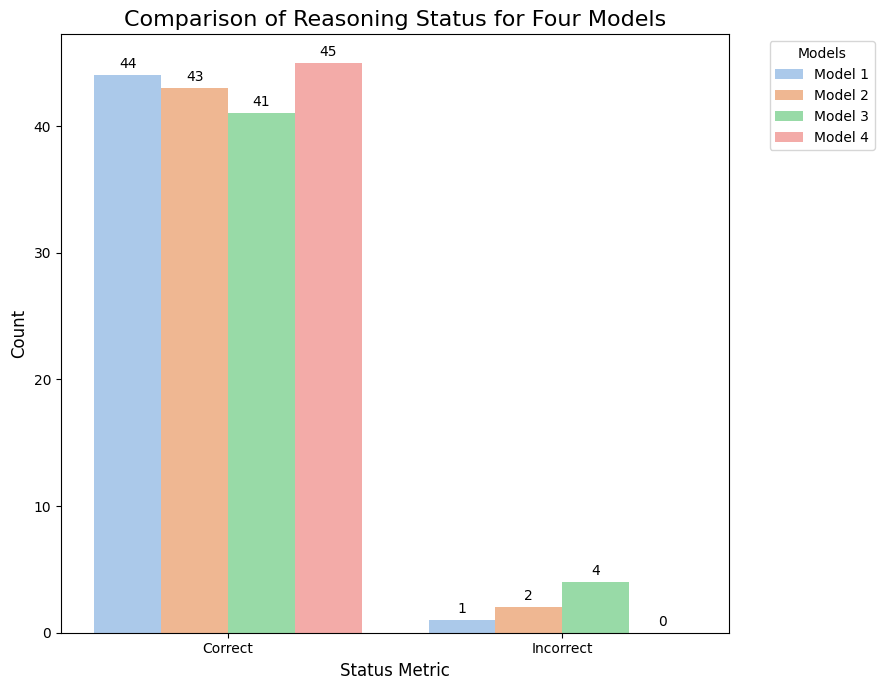

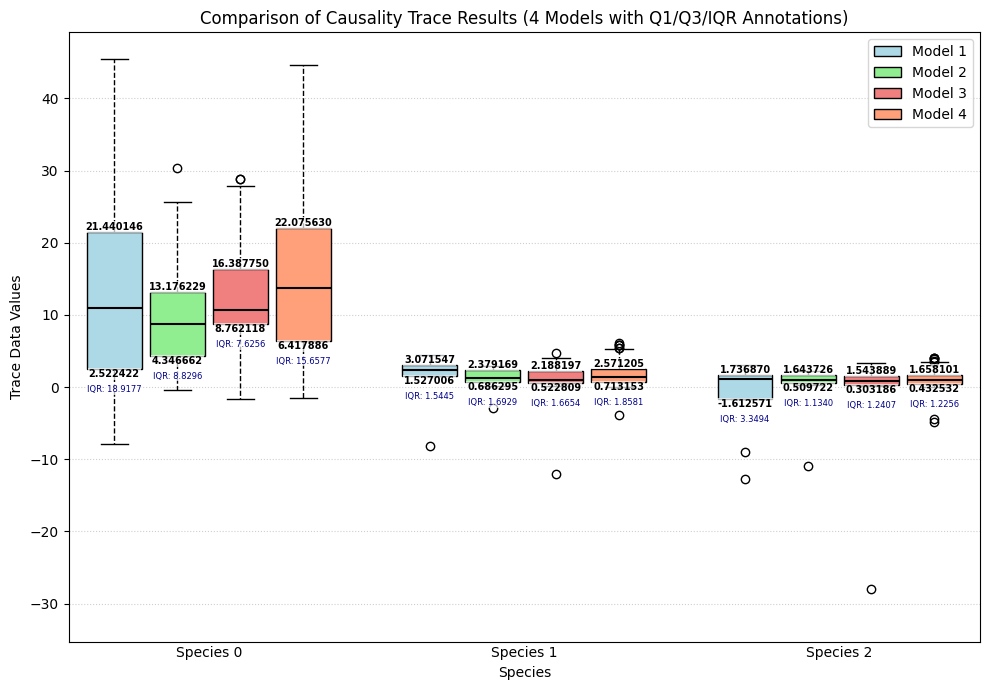

[Selects one random instance each for species 0, 1, and 2 to extract the 4th item from their CausalityTraces across four models; it then interpolates data to equal lengths per species and generates plots.]


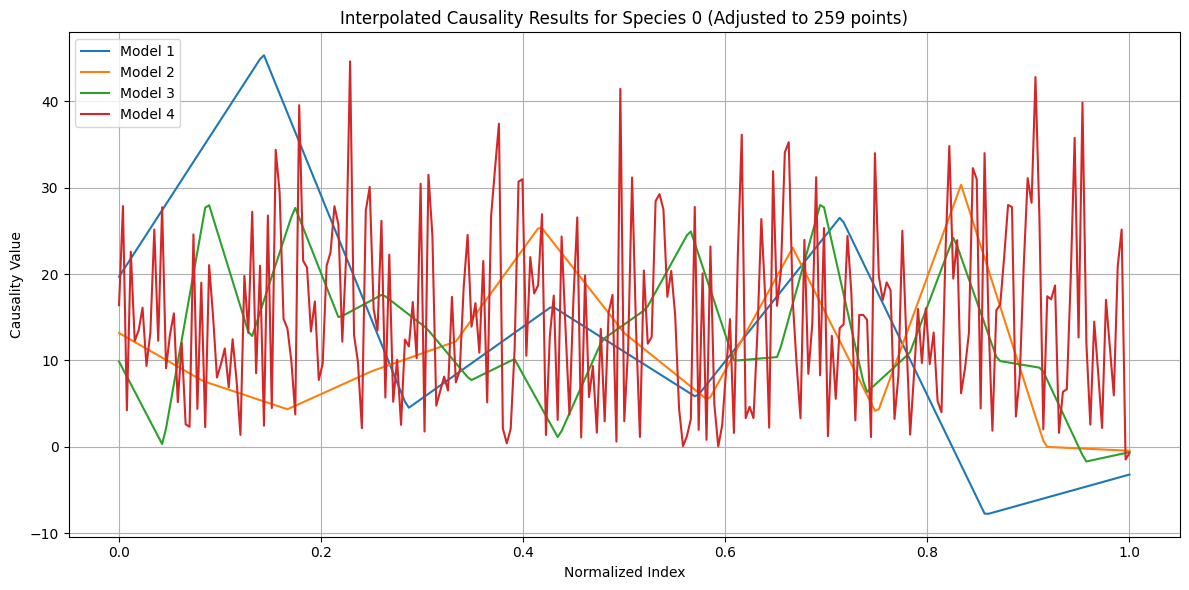

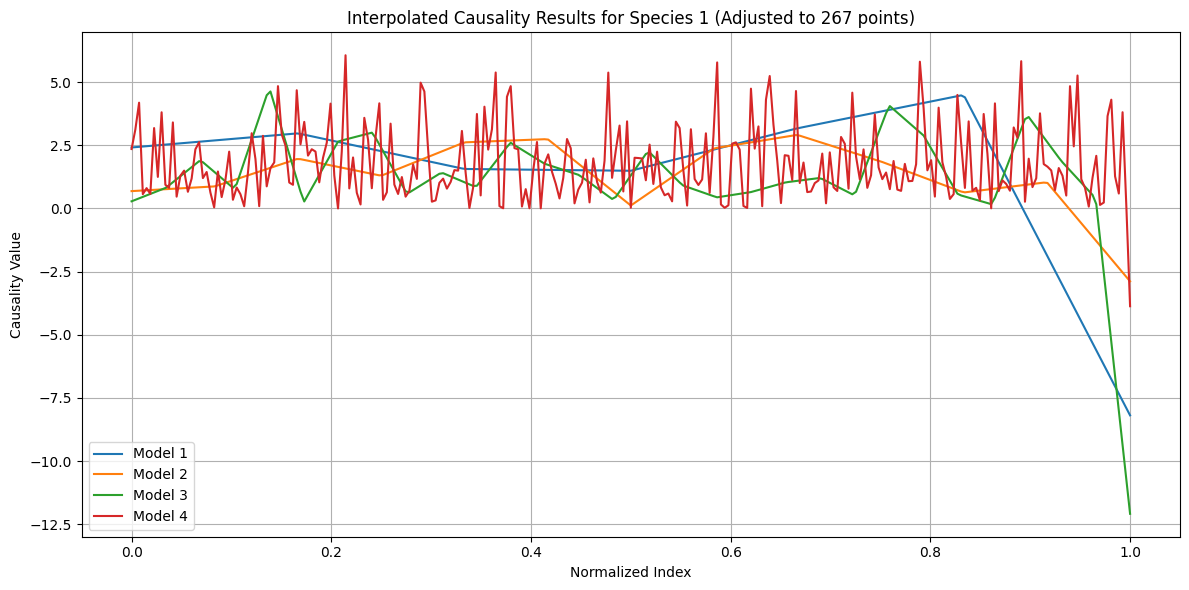

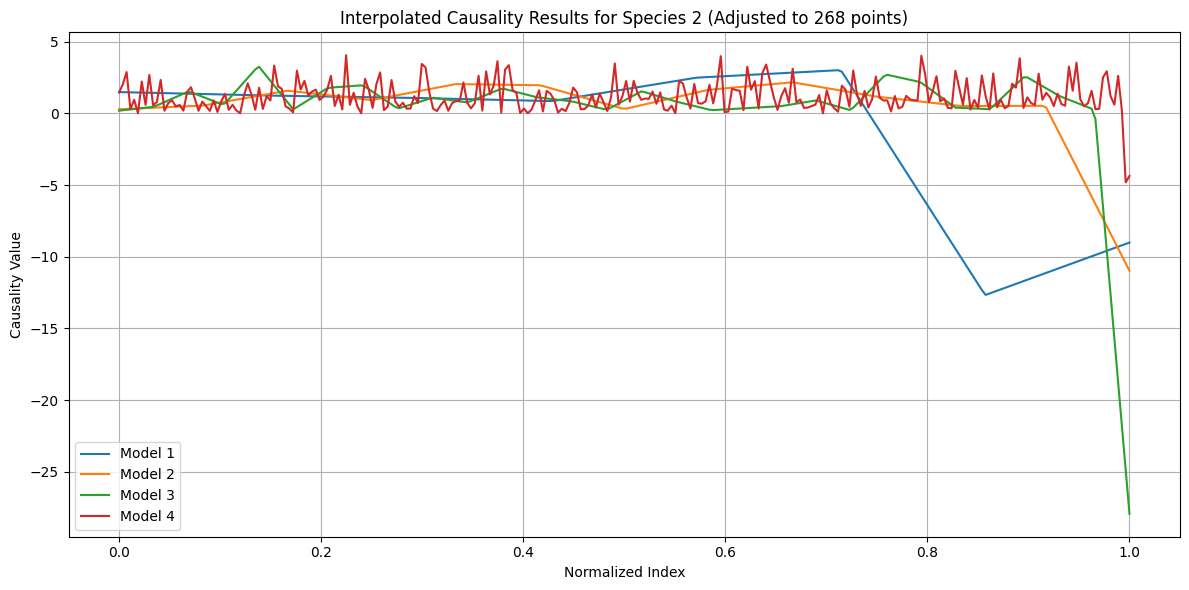

[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates line plots.]
model1['equal_causality_results'] {0: [15.483326, 35.715687, 4.665615, 13.562392, 6.7210083, 22.899853, -5.17033, -2.2649105], 1: [2.4525692, 2.907217, 1.559078, 1.4966716, 3.232853, 4.513475, -7.4269905], 2: [1.6243821, 1.7142165, 1.0350775, 1.0360563, 2.432895, 3.173142, -15.962019, -4.152]}
model2['equal_causality_results'] {0: [13.171582, 7.6048007, 4.3466616, 8.747185, 12.199853, 25.60206, 13.176229, 5.34553, 23.048208, 3.728166, 30.342943, -0.0028940807, -0.45554298], 1: [1.0435815, 1.2097614, 1.9333299, 1.6252904, 2.6653605, 2.972105, 0.09049036, 2.712151, 3.4910753, 2.0537467, 0.79303616, 1.0575855, -2.1814883], 2: [0.13159736, 0.45487493, 1.5117522, 0.823046, 1.8610014, 1.6

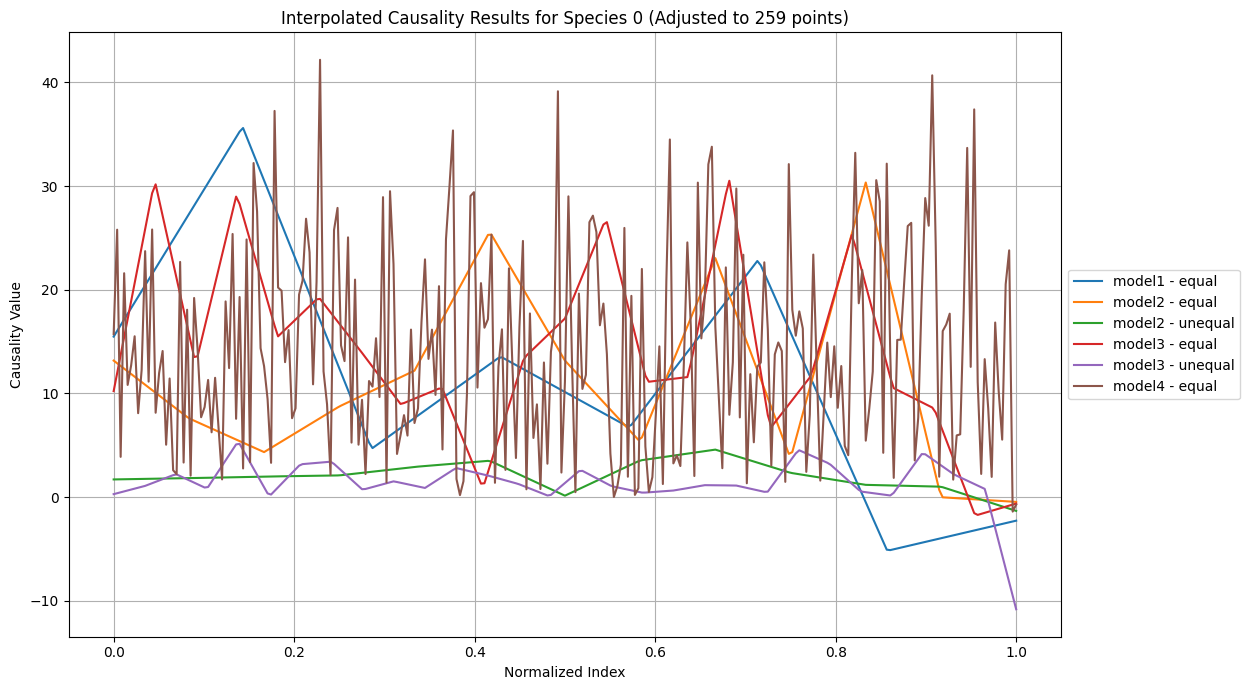

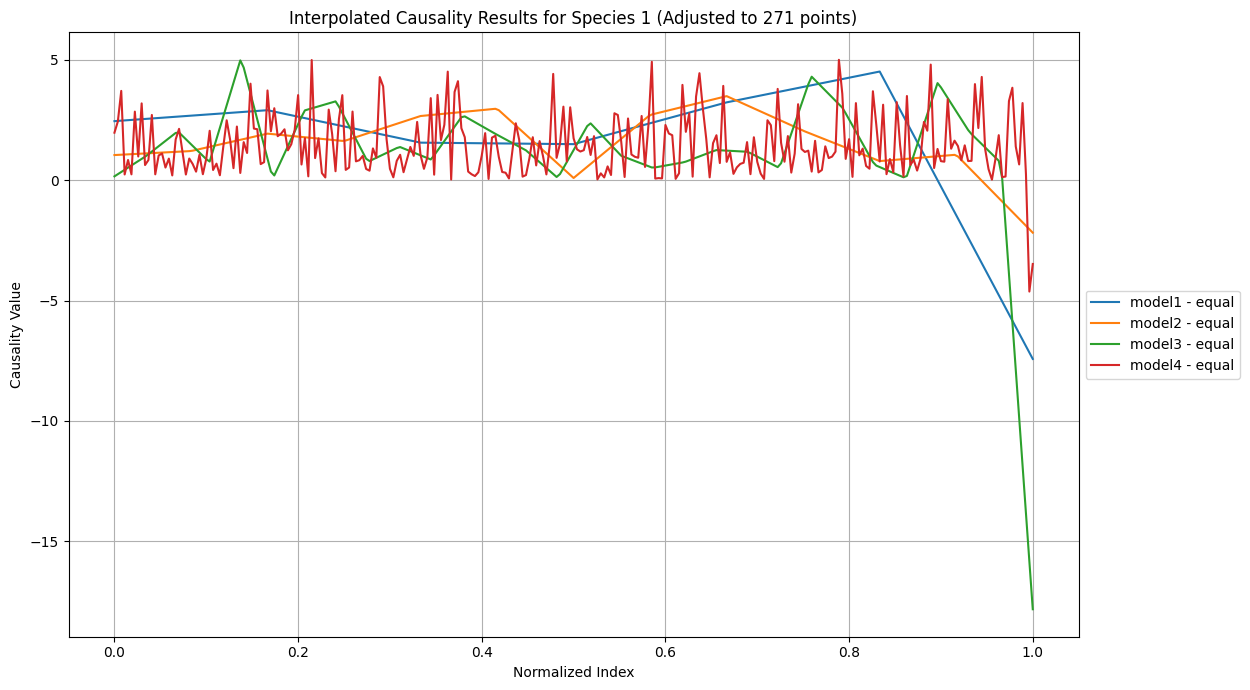

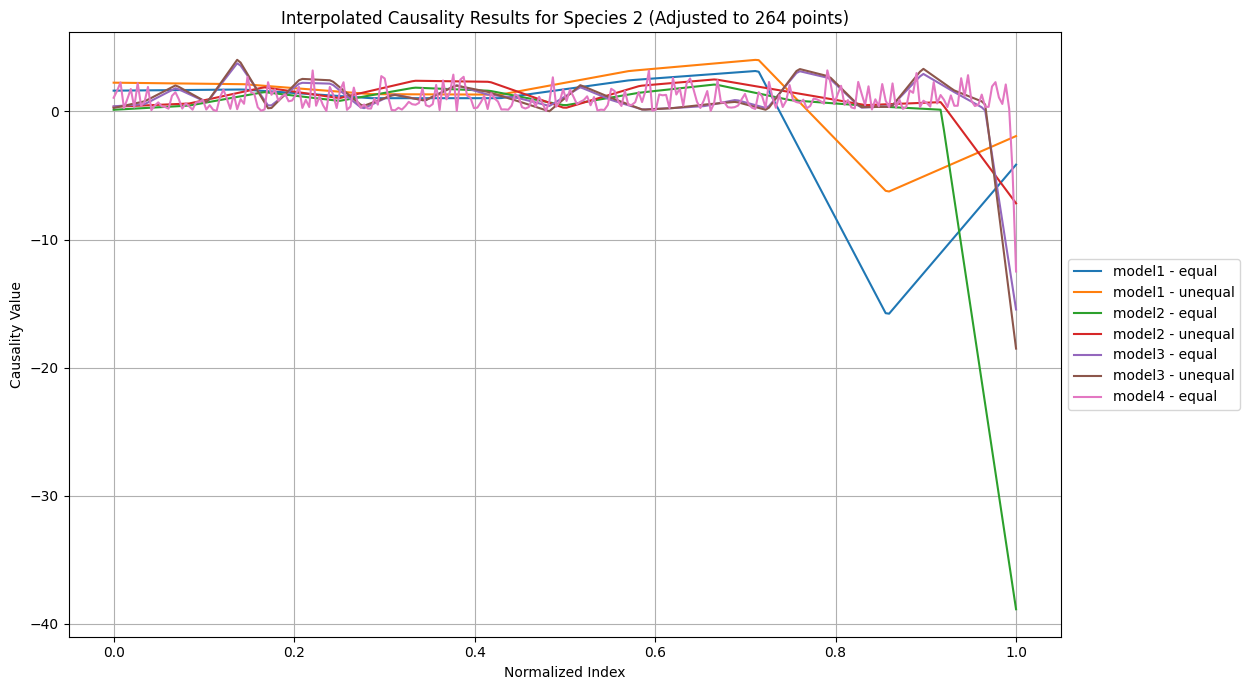

[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then interpolates data to equal lengths per species and generates Violin plots.]


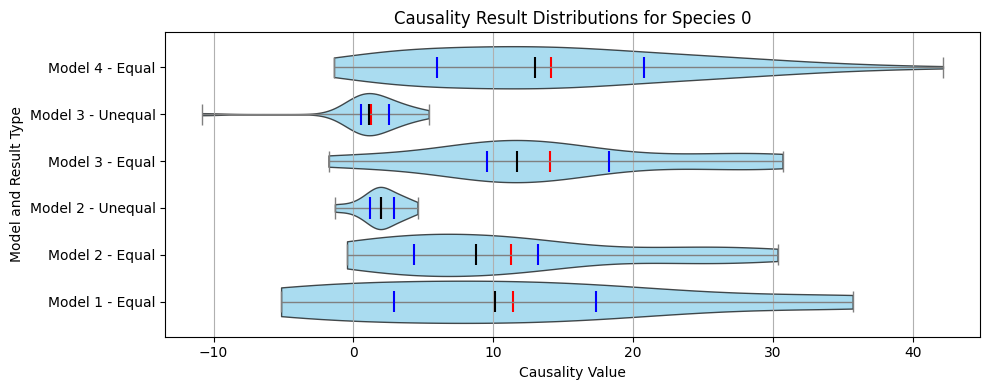

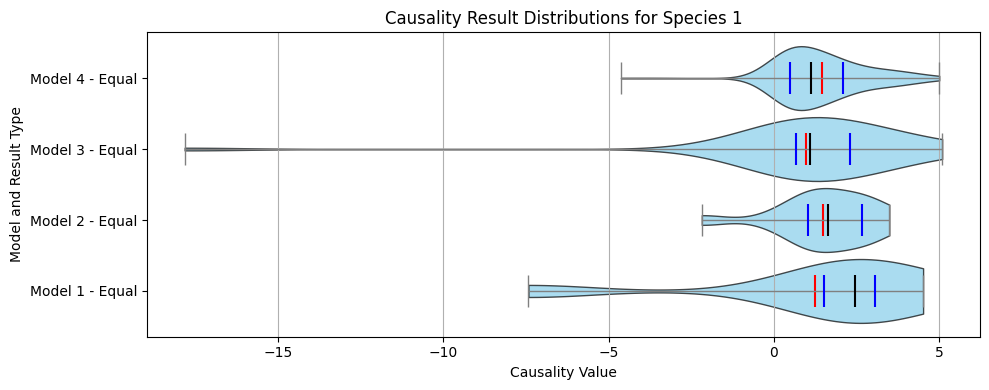

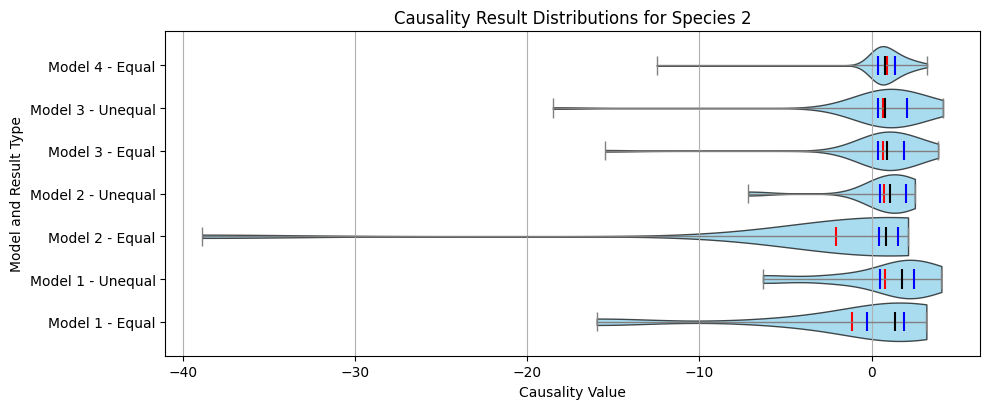

[From pools of correctly reasoned and incorrectly reasoned instances, this process selects one random instance for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces across four models; it then generates Box plots.]


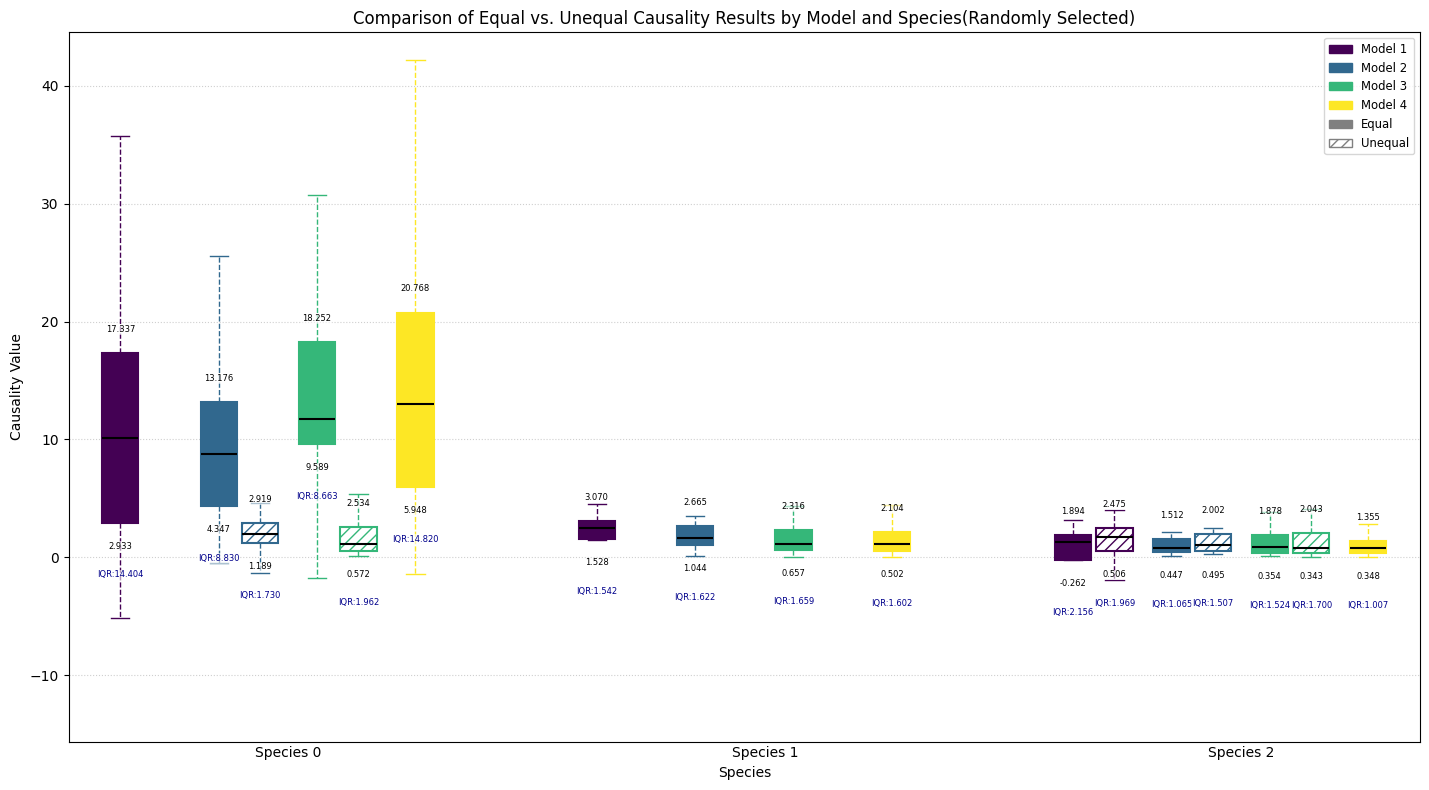


============== Average Causality Results =================
model1['equal_causality_averages'] {0: [21.714652666666666, 50.624078000000004, 5.658686046666667, 18.341596766666665, 7.183141559999999, 30.374160999999997, -7.197463033333333, -2.9543288200000006], 1: [2.5843386692307693, 2.976465923076923, 1.4843721692307692, 1.592297361538462, 3.2888025076923073, 4.571678723076922, -5.204972445692308, -3.6908643371428576], 2: [1.6798252125000002, 1.54113191875, 1.1426336693749999, 0.9810336106249999, 2.6169565749999997, 3.2731498187500003, -13.509529525000003, -6.575783512499999]}
model2['equal_causality_averages'] {0: [16.54929712142857, 9.068075276428571, 5.782509999999999, 10.314145257142856, 14.755688407142857, 30.08410914285714, 18.06198780714286, 8.101079192857142, 26.75895410714286, 6.128467264285715, 34.32241782142857, 2.546811718575715, -0.4151351085555556, -0.47205338], 1: [0.9295990961538461, 1.089784870769231, 1.855744246153846, 1.4670310153846151, 2.569868192307692, 2.85007315

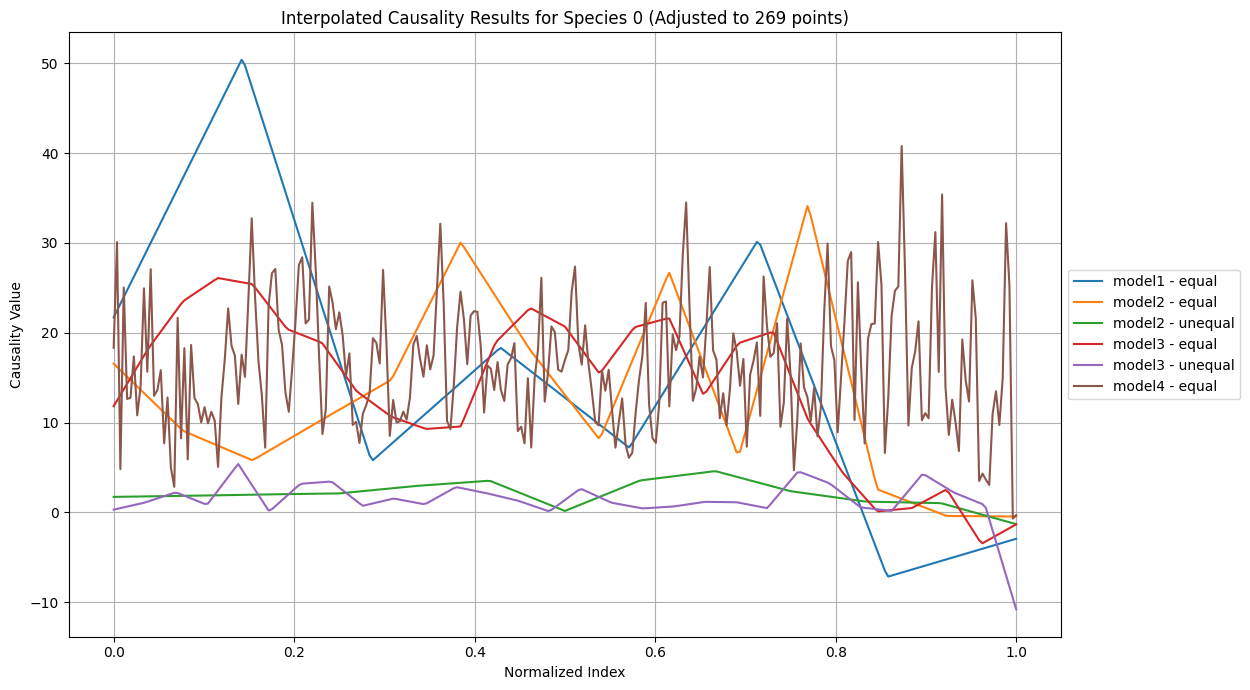

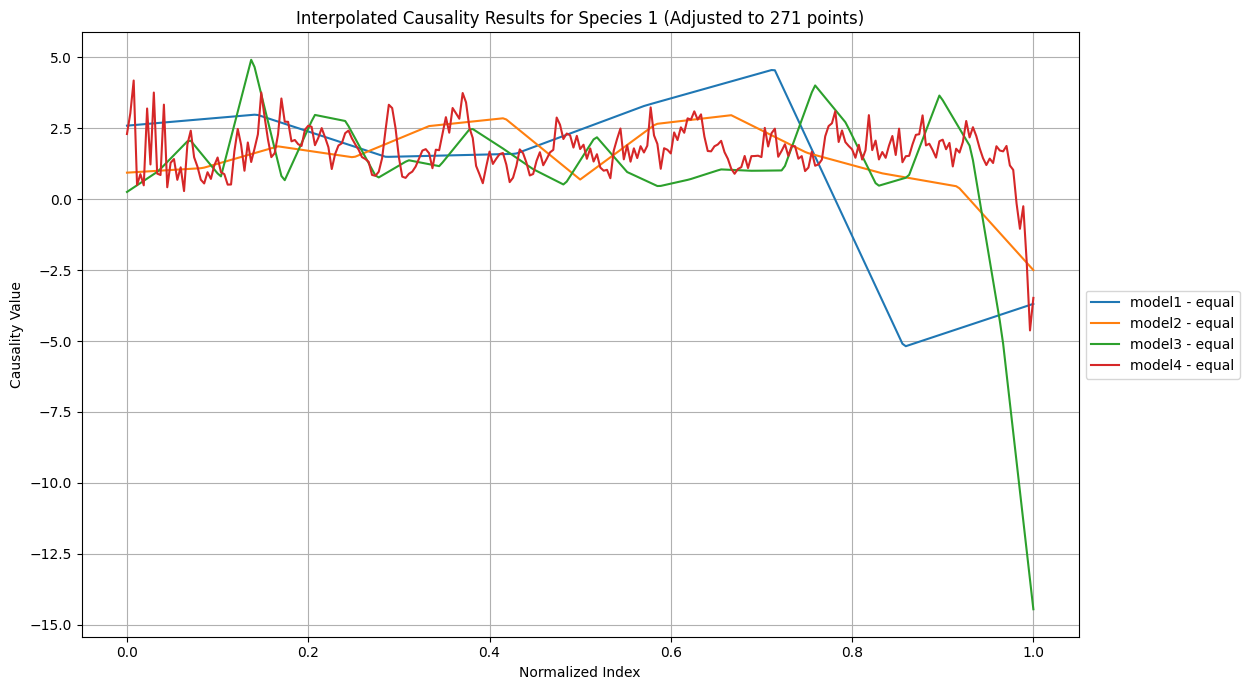

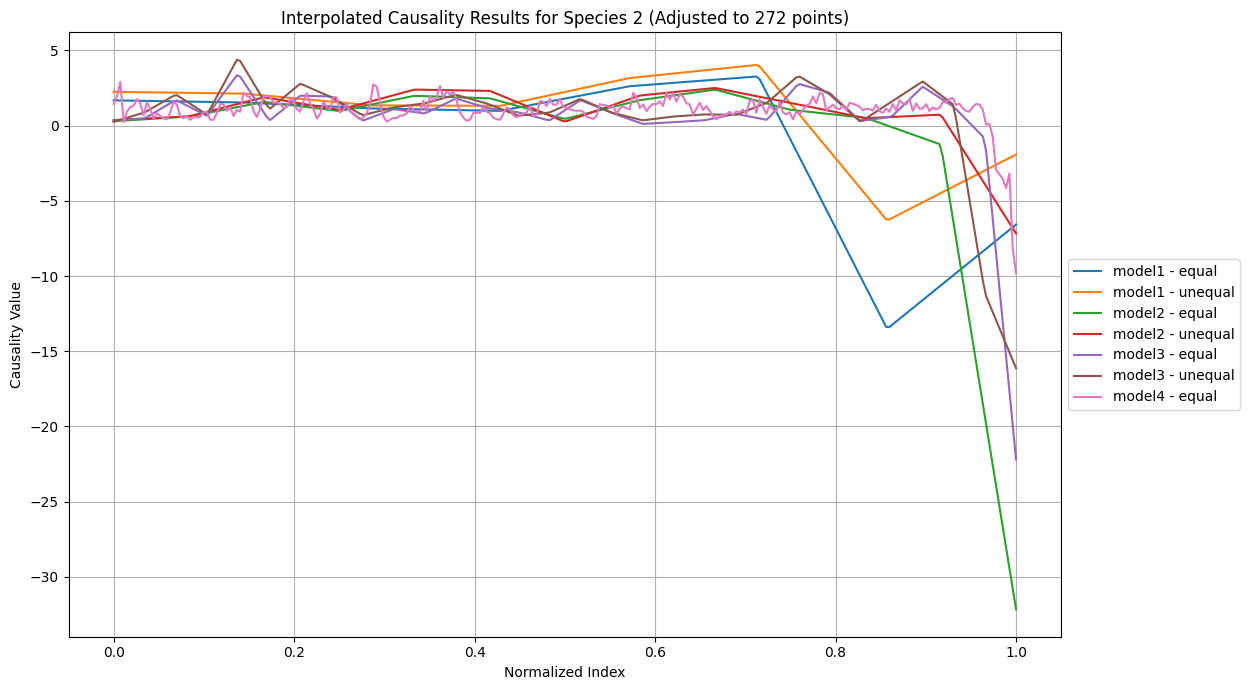


[From pools of correctly reasoned and incorrectly reasoned instances, this process seperates instances for each of species 0, 1, and 2, extracts the 4th item from their corresponding CausalityTraces and takes an avarage causality trace for each species across four models; it then generates Box plots.]


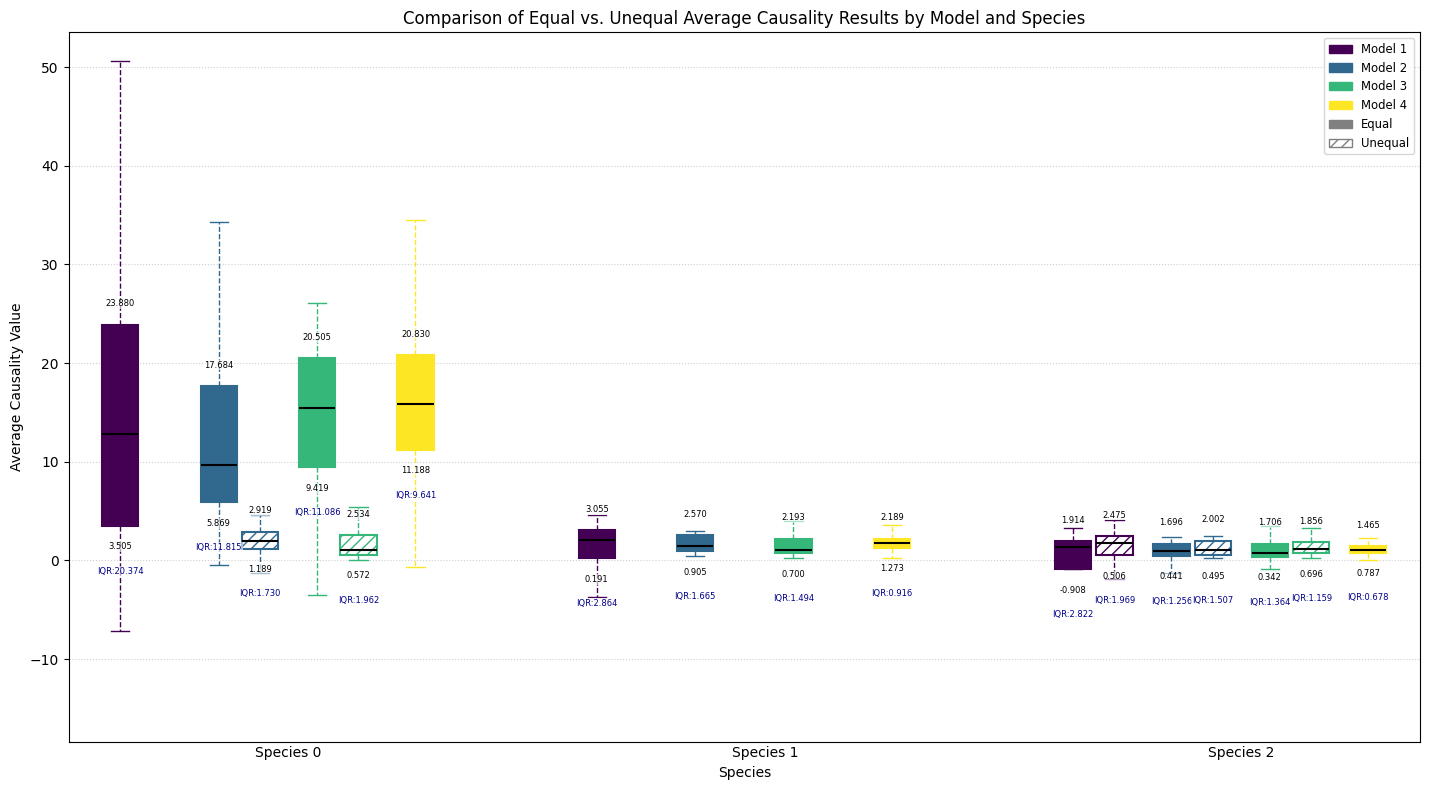

Checking image paths...
Image paths seem okay (files exist).

Displaying Markdown Report...


# ML Model Analytical Report

## Model: Model 1 (10 Nodes)

---

### 1. Executive Summary

* **Model Overview:** Multi-class classification predicting Iris species.

---

### 2. Model Details

* **Model Architecture:** The model architecture consists of an input layer with 4 nodes, a single hidden layer with 10 nodes, and an output layer with 3 nodes.
* **Training Data:**
    * Source and description: ../model_comparison/iris.1.csv
    * Size: 105 samples, 4 features.
    * Preprocessing: Standard Scaling (numerical), One-Hot Encoding (target).

---

### 3. Performance Metrics

#### 3.1. Evaluation Data
* Description: Iris Test Dataset
* Total Instances Evaluated: 45

#### 3.2. Quantitative Reasoning Metrics
* **Total Correctly Reasoned:** 44
* **Total Incorrectly Reasoned:** 1
* **Overall Accuracy:** 0.9778

---

### 4. Trace Variance Analysis

* **Definition:** Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.
* **Methodology:**  Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.
* **Results:**
    * Average Causality (Equal): `{0: [21.714652666666666, 50.624078000000004, 5.658686046666667, 18.341596766666665, 7.183141559999999, 30.374160999999997, -7.197463033333333, -2.9543288200000006], 1: [2.5843386692307693, 2.976465923076923, 1.4843721692307692, 1.592297361538462, 3.2888025076923073, 4.571678723076922, -5.204972445692308, -3.6908643371428576], 2: [1.6798252125000002, 1.54113191875, 1.1426336693749999, 0.9810336106249999, 2.6169565749999997, 3.2731498187500003, -13.509529525000003, -6.575783512499999]}`
    * Variance of Average Causality (Equal): `{0: {'Min point': 3.5054323300000005, 'Max point': 23.87952975, 'Variance': 20.37409742}, 1: {'Min point': 0.19056304263736257, 'Max point': 3.054550069230769, 'Variance': 2.8639870265934064}, 2: {'Min point': -0.9081706701562497, 'Max point': 1.914108053125, 'Variance': 2.82227872328125}}`
    * Average Causality (Unequal): `{2: [2.2466605, 2.135561, 1.3494105, 1.3145678, 3.1611788, 4.045268, -6.313188, -1.9202654]}`
    * Variance of Average Causality (Unequal): `{2: {'Min point': 0.5058595000000001, 'Max point': 2.475290075, 'Variance': 1.969430575}}`

---

### 5. Operational Metrics

* **Workflow Execution Time:** `{'1_create_request': 1.4460581000003003, '2_create_client': 3.6999999792897142e-06, '3_upload_context': 8.774401000000125, '4_create_graph': 5.030231400000048, '5_upload_embedding_model': 0.7285044000000198, '6_upload_embedding_config': 0.7565528999998605, '7_upload_model_case_data': 0.7012846000002355, '8_process_embedded_model': 39.6311155999997, '9_get_reasoning_trace': 21.18745919999992, '10_get_reasoning_status': 295.7860155999997, 'total_workflow_time': 374.0420710000003}`
* **Model Size:** 3.28 KiB

---
---


## Model: Model 2 (20 Nodes)

---

### 1. Executive Summary

* **Model Overview:** Multi-class classification predicting Iris species.

---

### 2. Model Details

* **Model Architecture:** The model architecture consists of an input layer with 4 nodes, a single hidden layer with 20 nodes, and an output layer with 3 nodes.
* **Training Data:**
    * Source and description: ../model_comparison/iris.1.csv
    * Size: 105 samples, 4 features.
    * Preprocessing: Standard Scaling (numerical), One-Hot Encoding (target).

---

### 3. Performance Metrics

#### 3.1. Evaluation Data
* Description: Iris Test Dataset
* Total Instances Evaluated: 45

#### 3.2. Quantitative Reasoning Metrics
* **Total Correctly Reasoned:** 43
* **Total Incorrectly Reasoned:** 2
* **Overall Accuracy:** 0.9556

---

### 4. Trace Variance Analysis

* **Definition:** Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.
* **Methodology:**  Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.
* **Results:**
    * Average Causality (Equal): `{0: [16.54929712142857, 9.068075276428571, 5.782509999999999, 10.314145257142856, 14.755688407142857, 30.08410914285714, 18.06198780714286, 8.101079192857142, 26.75895410714286, 6.128467264285715, 34.32241782142857, 2.546811718575715, -0.4151351085555556, -0.47205338], 1: [0.9295990961538461, 1.089784870769231, 1.855744246153846, 1.4670310153846151, 2.569868192307692, 2.850073153846154, 0.6872703191538463, 2.6433503923076924, 2.9526429307692315, 1.630164263846154, 0.9052205815384615, 0.4418032530769231, -2.5021710436363636], 2: [0.2962163325, 0.602412735, 1.5750156624999998, 0.9728483800000001, 1.98295018125, 1.8191055749999998, 0.440623044375, 1.6961391000000003, 2.394891975, 1.05088648375, 0.516843225625, -1.2584474246875001, -32.14943921428572]}`
    * Variance of Average Causality (Equal): `{0: {'Min point': 5.868999316071428, 'Max point': 17.683815135714287, 'Variance': 11.81481581964286}, 1: {'Min point': 0.9052205815384615, 'Max point': 2.569868192307692, 'Variance': 1.6646476107692305}, 2: {'Min point': 0.440623044375, 'Max point': 1.6961391000000003, 'Variance': 1.2555160556250002}}`
    * Average Causality (Unequal): `{0: [1.7108961, 1.8309841, 1.9863389, 2.1001723, 2.9194777, 3.5151412, 0.14566508, 3.543755, 4.5866003, 2.3464208, 1.1892413, 1.0133398, -1.3226131], 2: [0.3669504, 0.6158785, 1.8866407, 1.0407456, 2.3970628, 2.3145156, 0.25504953, 2.0022414, 2.5054145, 1.5142025, 0.4951029, 0.72895896, -7.1702356]}`
    * Variance of Average Causality (Unequal): `{0: {'Min point': 1.1892413, 'Max point': 2.9194777, 'Variance': 1.7302364}, 2: {'Min point': 0.4951029, 'Max point': 2.0022414, 'Variance': 1.5071385}}`

---

### 5. Operational Metrics

* **Workflow Execution Time:** `{'1_create_request': 1.2142989999993006, '2_create_client': 3.200000719516538e-06, '3_upload_context': 4.796342200000254, '4_create_graph': 4.515467499999431, '5_upload_embedding_model': 0.7027785999998741, '6_upload_embedding_config': 0.7322777999997925, '7_upload_model_case_data': 0.7210033000001204, '8_process_embedded_model': 35.88038830000005, '9_get_reasoning_trace': 23.62813230000029, '10_get_reasoning_status': 331.00039950000064, 'total_workflow_time': 403.1934745000008}`
* **Model Size:** 4.87 KiB

---
---


## Model: Model 3 (50 Nodes)

---

### 1. Executive Summary

* **Model Overview:** Multi-class classification predicting Iris species.

---

### 2. Model Details

* **Model Architecture:** The model architecture consists of an input layer with 4 nodes, a single hidden layer with 50 nodes, and an output layer with 3 nodes.
* **Training Data:**
    * Source and description: ../model_comparison/iris.1.csv
    * Size: 105 samples, 4 features.
    * Preprocessing: Standard Scaling (numerical), One-Hot Encoding (target).

---

### 3. Performance Metrics

#### 3.1. Evaluation Data
* Description: Iris Test Dataset
* Total Instances Evaluated: 45

#### 3.2. Quantitative Reasoning Metrics
* **Total Correctly Reasoned:** 41
* **Total Incorrectly Reasoned:** 4
* **Overall Accuracy:** 0.9111

---

### 4. Trace Variance Analysis

* **Definition:** Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.
* **Methodology:**  Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.
* **Results:**
    * Average Causality (Equal): `{0: [11.826794457142858, 18.24753938428571, 23.514515325, 26.099202857142863, 25.411488385714282, 20.39713564285714, 18.886430535714283, 13.474457496428569, 10.64610875142857, 9.28183229142857, 9.557103802142858, 18.92214028571429, 22.76268330714285, 20.686236537857145, 15.42280527857143, 20.613640192857144, 21.652255364285715, 13.005825071428566, 18.84026627142857, 20.130083992857145, 10.335008250000001, 4.4099605678571425, 0.09016772538461536, 0.47278079833333336, 2.5577352, -3.5193202, -1.3492545], 1: [0.24998662461538457, 0.9802865492307693, 2.1077754307692307, 0.7673908607692307, 5.014046838461539, 0.5485595458461539, 2.965656, 2.745155547692308, 0.7254517538461538, 1.3697384769230767, 1.1568350261538463, 2.5108230153846147, 1.8014828, 1.0488924953846155, 0.4934609748769231, 2.2217269384615386, 0.9531537869230768, 0.4433690153846154, 0.6909349899999999, 1.0441291484615385, 0.995047146153846, 1.0083616630769232, 4.0254870153846145, 2.686561030769231, 0.451768056923077, 0.7765228753846153, 3.6666399230769233, 1.807569003076923, -4.77565573076923, -14.447023999999999], 2: [0.3423980435714285, 0.4849324064285714, 1.7102682857142855, 0.6515844535714285, 3.463380585714286, 0.325407045, 1.9921179071428574, 1.9361621642857145, 0.32490315428571426, 1.098223165357143, 0.8029450942857143, 1.808863757142857, 1.1738896271428572, 0.88813134, 0.34241494999999994, 1.6937448857142854, 0.8563882771428573, 0.1125385562857143, 0.2265983992857143, 0.3612904307142858, 0.7836947757142857, 0.37830726385714286, 2.7848295785714288, 2.194697297142857, 0.30748143107142856, 0.5919069214285715, 2.5908988785714286, 1.242399664285714, -0.8611541788571427, -22.198404076923076]}`
    * Variance of Average Causality (Equal): `{0: {'Min point': 9.419468046785713, 'Max point': 20.505387917857142, 'Variance': 11.085919871071429}, 1: {'Min point': 0.6995641809615384, 'Max point': 2.1932390615384616, 'Variance': 1.4936748805769233}, 2: {'Min point': 0.3424022701785714, 'Max point': 1.7061374357142856, 'Variance': 1.3637351655357142}}`
    * Average Causality (Unequal): `{0: [0.2927441, 1.0764204, 2.2262857, 0.82188624, 5.3889146, 0.07427674, 3.1702905, 3.4283721, 0.71630675, 1.5304645, 0.88178384, 2.8130207, 2.1070771, 1.2789898, 0.09193082, 2.6369057, 1.0614313, 0.42649573, 0.6448702, 1.1608781, 1.1252497, 0.45659202, 4.560985, 3.229469, 0.54758793, 0.14573593, 4.301323, 2.1951182, 0.78434443, -10.806031], 2: [0.2565365233333333, 0.8801067666666667, 2.0714540666666665, 0.7263962, 4.530069200000001, 1.0810978233333333, 2.793005966666667, 1.8822455866666665, 0.6905727333333332, 1.2105648, 1.4847540866666666, 2.0488852333333334, 1.4649806666666667, 0.6601815866666666, 0.8690320530000001, 1.7754879666666668, 0.86845592, 0.3502905633333333, 0.6071380966666666, 0.7462185433333334, 0.7135272233333333, 1.5244968566666666, 3.313317766666666, 2.097265, 0.24809208666666668, 1.5879300833333332, 2.9378686333333337, 1.3711313233333333, -11.150362346666666, -16.124993]}`
    * Variance of Average Causality (Unequal): `{0: {'Min point': 0.5719084975, 'Max point': 2.5342507, 'Variance': 1.9623422025}, 2: {'Min point': 0.6963113558333333, 'Max point': 1.8555561816666666, 'Variance': 1.1592448258333334}}`

---

### 5. Operational Metrics

* **Workflow Execution Time:** `{'1_create_request': 1.2508037999996304, '2_create_client': 4.73000000056345e-05, '3_upload_context': 5.203454299999976, '4_create_graph': 32.883887799999684, '5_upload_embedding_model': 1.059838999999556, '6_upload_embedding_config': 0.7708085000003848, '7_upload_model_case_data': 0.776659699999982, '8_process_embedded_model': 35.722075499999846, '9_get_reasoning_trace': 19.36122879999948, '10_get_reasoning_status': 313.19834699999956, 'total_workflow_time': 410.22811980000006}`
* **Model Size:** 14.12 KiB

---
---


## Model: Model 4 (500 Nodes)

---

### 1. Executive Summary

* **Model Overview:** Multi-class classification predicting Iris species.

---

### 2. Model Details

* **Model Architecture:** The model architecture consists of an input layer with 4 nodes, a single hidden layer with 500 nodes, and an output layer with 3 nodes.
* **Training Data:**
    * Source and description: ../model_comparison/iris.1.csv
    * Size: 105 samples, 4 features.
    * Preprocessing: Standard Scaling (numerical), One-Hot Encoding (target).

---

### 3. Performance Metrics

#### 3.1. Evaluation Data
* Description: Iris Test Dataset
* Total Instances Evaluated: 45

#### 3.2. Quantitative Reasoning Metrics
* **Total Correctly Reasoned:** 45
* **Total Incorrectly Reasoned:** 0
* **Overall Accuracy:** 1.0000

---

### 4. Trace Variance Analysis

* **Definition:** Causality Trace represents internal activations within different layers of the AI model as it processed input case for the Iris dataset.Low variance in causality trace results for a specific reasoning case is a strong indicator that the model employs a consistent and reliable internal mechanism for that task, which generally supports dependable performance within that specific context.
* **Methodology:**  Instances were separated into correct and incorrect reasoning pools, then isolated by species (0, 1, 2). Fourth elements were extracted from the corresponding CausalityTraces. Averages of these fourth elements were calculated per reasoning pool, species, and model (of the four used). Finally, the variance across these four model-specific averages was computed for each species and reasoning pool combination.
* **Results:**
    * Average Causality (Equal): `{0: [18.31831791333333, 30.100456599999998, 4.801472980000001, 25.04217222, 12.622408686666668, 12.752065479999999, 17.36971119333333, 10.801186440000002, 14.004050786666669, 24.950980480000002, 15.655186826666665, 27.074198213333332, 12.963503021333336, 13.613118166666668, 15.830371653333335, 7.679264006666666, 12.7821069, 4.9438285933333335, 2.831230184, 21.66349029066667, 8.239709019066668, 18.280467426000005, 5.89275156, 18.637115478000002, 12.724530581333333, 12.051456962, 10.012198902000002, 11.708815806666667, 9.911672013333336, 11.183030333333333, 10.23097072, 5.049142166666666, 12.794722297333331, 17.02914584666667, 22.708103544666667, 18.561860866666667, 17.430495193333332, 12.06785778666667, 17.562352606666664, 15.088336720000001, 23.657388109333333, 32.75585122, 23.85762204666667, 16.85195124, 13.03368838, 7.194022214666666, 22.989760644, 26.629728240000002, 27.109189220000005, 20.30434833333333, 18.6423899, 13.366877766666665, 11.18847919333333, 16.004989433333336, 21.250081100000003, 27.54884144666666, 28.41091166666667, 21.035079206666662, 21.4709454, 34.48373206666666, 27.09443035333333, 17.443277107666667, 8.713925160666665, 11.471050456, 25.147889153333328, 23.376512153333337, 20.3992099, 22.27714848666666, 19.717387173333332, 15.189391346666666, 17.69516236, 9.73388656, 10.068397559999998, 7.714573893333333, 10.99009283866667, 11.930352676666665, 13.260261939999998, 19.39217474666667, 18.877892550666665, 16.578842713333337, 26.994366006666667, 18.875100066666665, 8.507790987333333, 12.509368306666666, 10.008123498, 10.139767193333334, 11.208423399999997, 10.326754666666668, 12.849853893333336, 18.70076370666667, 19.64006517333333, 17.054222166666662, 15.105050413333334, 18.604047966666666, 15.922926279999997, 17.4653318, 24.727563739999997, 32.14172683333333, 23.207406037333328, 10.166308428666667, 9.25075462, 14.148469990666666, 20.619542162666672, 24.582122776666665, 21.52702492, 16.498173666666666, 21.90572473333333, 22.404575620000003, 22.338672213333332, 18.514750998, 11.108811846666667, 16.348102540000003, 15.995910146666667, 13.630165766666666, 16.72535086, 13.612584576, 12.393582199999999, 16.45886820666667, 17.167028733333332, 18.849933586666666, 9.049371944, 9.527223232, 7.677335551333334, 14.938065683333333, 7.21758785, 14.9282613, 18.082907697333333, 26.117317157333336, 12.326065494666668, 15.60147804, 20.703146850666666, 20.076631299999995, 15.88399359413333, 15.667812446666666, 16.955618631333333, 18.060500119999997, 24.543576026666663, 27.372554153333326, 18.72203628666666, 16.448267573333332, 20.829726973333333, 16.534430511333333, 13.488102533333334, 10.070496086733332, 9.676431780666665, 15.773680413333333, 13.54033843, 15.873319793333335, 11.331725988666669, 7.196050916000001, 9.997825674, 12.685212570666668, 7.581108193333333, 6.069645791133332, 6.625639846666667, 11.059600204000002, 14.734611133333336, 17.370560526666665, 23.327577607800002, 11.993037046666666, 8.2686552, 7.720812371333333, 12.074370606666667, 23.33339260666667, 23.482896679999993, 11.788905646666667, 19.805139434666664, 18.061870526666667, 19.57905777666667, 28.699593380000003, 34.510676800000006, 22.90735265333333, 12.411310760000001, 13.822093373333333, 17.33761666, 15.02858856, 20.770685126666667, 27.321362226666665, 18.041633566666672, 16.99006686, 10.484785320000002, 13.266114606666667, 9.700240516, 13.697455973333332, 19.93038328, 17.9540753928, 14.093398786666665, 17.079879440000003, 7.310919973333335, 15.32364126666667, 16.86747492, 18.91776556466667, 10.733932833333336, 26.27328109333333, 20.766654886666664, 17.30828764, 17.7316964, 21.04788552, 9.525899513333334, 12.218584926666667, 21.58538702666667, 15.258725990666669, 4.67513076, 10.326271386666667, 18.809314713333332, 13.901204600000002, 12.836135413333334, 10.158115126666665, 13.853157733333335, 8.463316946666664, 11.685999306666666, 22.367230866666667, 29.939821575333333, 18.50550086533333, 16.984656025333337, 8.909815933333332, 15.143644593333333, 21.193987506666666, 28.0067829308, 28.985884899999995, 10.273162528, 25.624992302666666, 15.88124672, 7.666775920000001, 19.335091098, 20.957475916666674, 21.030177933333334, 30.105287378933333, 25.319886594666666, 6.602351466666667, 12.587591393333334, 21.85898578, 24.67557113086667, 25.150216636, 40.80158373333333, 26.72342102933333, 9.669590159999997, 16.085797497333335, 17.910736946666663, 21.273439993333334, 10.24910004933333, 11.041752680000002, 10.478767786666667, 25.09592925333333, 31.213780760000002, 15.636190313333337, 35.40383390666667, 14.011538613333334, 8.616689386666668, 12.541365046666668, 9.997502033333335, 6.8192107973333345, 19.250151980000002, 14.74707876666667, 12.344093221428574, 25.842123162857142, 21.621045635714285, 3.4807311264285707, 4.311986200769231, 3.6355310199999997, 3.0430761750000004, 10.957944766666666, 13.477865433333333, 9.719065866666666, 14.933651000000001, 32.214332999999996, 25.2035045, -0.7002310199999999, -0.3199753], 1: [2.290155130769231, 3.0225081615384615, 4.1745343923076925, 0.49555986846153843, 0.8772919923076924, 0.48384225846153855, 3.1895217461538463, 1.217711269230769, 3.750983769230769, 0.8966079676923076, 0.8463780553846155, 3.325113538461539, 0.4153653438461538, 1.277709692307692, 1.4087433076923075, 0.6760778576923078, 1.1172780823076924, 0.2809780462307692, 1.9270845223076922, 2.4089004000000003, 1.4719654384615384, 1.1397991507692309, 0.6808006433076923, 0.5490807127692308, 0.9445282161538459, 0.7096386207692308, 1.1796364215384614, 1.4630625146153844, 0.9463298992307693, 0.8766106907692307, 0.5080960730769231, 0.5124491516923078, 1.686404919846154, 2.469232646153846, 1.9092895607692308, 0.9971751750769232, 1.9915145776923078, 1.3045108984615388, 1.779153601538462, 2.279119446153846, 3.752614784615384, 2.8871393692307694, 2.098096346153846, 1.4756330415384618, 1.6157348661538462, 2.275717119076923, 3.5413311615384613, 2.723469438461538, 2.720045715384615, 2.0318605, 2.0803242692307693, 1.9319327192307691, 1.868004253846154, 2.438358123076923, 2.583843936923077, 2.5434569775030766, 1.8970827479230767, 2.156065375730769, 2.4987167075384615, 2.175879183076923, 1.8265623961538462, 1.056560003076923, 1.5830482765384615, 1.8859145676153846, 1.9637056046153847, 2.3194219715384614, 2.4129702646153843, 2.1383625084615385, 1.9286483684615388, 1.736670816923077, 1.4780652853846155, 1.4097711946153846, 1.3098441515384613, 0.8495790907692308, 0.8187964392307692, 0.9624090623076923, 1.4377888300000001, 2.40719116, 3.3208762538461536, 3.2044162515384618, 2.497032934615384, 1.4681654961538462, 0.7897393076923078, 0.7452953884615384, 0.8896197807692309, 0.9665546046153846, 1.1451521738461539, 1.4306668884615388, 1.7073999999999996, 1.7575293353846153, 1.612764143307692, 1.0857806184615386, 1.7383816950000002, 1.7205902077692303, 2.305104026923077, 2.8842267176923078, 2.336113963846154, 3.206400903076923, 3.0217995833076925, 2.8288536636892307, 3.734165804999999, 3.404652945384615, 2.513327781856923, 2.1505229707692304, 1.166673951153846, 0.8725724491538459, 0.5574930171538462, 1.1328491515384616, 1.6714164476923077, 1.2365487789999998, 1.4193790863076925, 1.5838139152307693, 1.6204067458461542, 1.2146051407692309, 0.596222336, 0.7499506226923078, 1.1654639896923078, 1.7493930176923078, 1.6119878992307692, 1.2788663130769236, 0.8309132761538461, 0.88218983, 1.341917505384615, 1.64927121, 1.1901879715384616, 1.4051836023076922, 1.6421930015384614, 1.733818586923077, 2.87021296923077, 2.6160865215384623, 2.114755222307692, 2.3075208792307693, 2.246884178461538, 1.8126927167692306, 2.2260654985000006, 1.7616053850769229, 1.912925476923077, 1.4176309769230764, 1.7826412046153846, 1.3217509292307692, 1.5791173669230767, 1.109781823076923, 0.9988489392307692, 1.0286789953846154, 0.7330719260769231, 1.7027243284615385, 2.1174378543846153, 2.484251630769231, 1.3977943273076927, 1.8935839684615385, 1.315680863846154, 1.7851472700000004, 1.4435295600000002, 1.8609794561538466, 1.6398749469230771, 1.8783946215384615, 3.2278049199999996, 2.2410270863846153, 1.9422590099999997, 1.065814188846154, 1.7905007072307693, 1.7345748350769237, 1.6062591314615384, 2.345644365384615, 2.0773033868999997, 2.5237115133076924, 2.334730921846154, 2.841901153076923, 2.797043618461539, 3.088476648846154, 2.799028159384615, 2.98245248, 2.202649023076923, 1.6922701184615385, 1.67976644, 1.8581775184615383, 1.9214702846153844, 2.049451842, 1.650743460769231, 1.415136473076923, 1.0681153230769231, 0.8904803692307693, 1.0587096469230768, 1.123110536923077, 1.5169392884615385, 1.0914153944223075, 1.510596124615385, 1.515147688230769, 1.5266375415384614, 1.477644945356154, 2.5065380507692314, 1.8506557892307691, 2.3181726107692304, 2.478736861538462, 1.489271723076923, 1.6944012076923076, 1.9306664961538458, 1.5209054230769232, 1.866258750769231, 1.86051472, 1.4212200415384617, 1.511715472307692, 0.984899096923077, 1.1090882946153846, 1.6660592515384613, 1.1728423161538462, 1.2209458115384615, 1.3875283046153846, 2.211188126923077, 2.568658238461538, 2.6692212846153844, 3.0925884384615383, 2.0092971884615385, 2.4171764253846155, 2.0051324569230764, 1.8679561561538462, 1.7506790538461536, 1.4548360669230773, 1.9110688907692308, 1.3911947123076922, 1.7199401153846154, 2.955127787692308, 1.7229694453846152, 2.058865440769231, 1.394456687692308, 1.6560700576923078, 1.4522205815384615, 1.8819135449230766, 2.2202048723076926, 1.5525254588923074, 2.4788716053846156, 1.295949553076923, 1.5081266923076921, 1.5224147038461537, 1.925675526153846, 2.2604214076923084, 2.2840982584615386, 2.9463987692307687, 1.890287175384615, 1.9475759130769232, 1.7253499146153846, 1.4594062384615387, 2.0362021384615385, 2.0910513646153848, 1.7542228384615381, 1.977317326923077, 1.1487633892307691, 1.7729950899999996, 1.6372516307692306, 2.008174814615385, 2.7496866584615387, 2.170528094692308, 2.530314381923077, 2.219391379846154, 1.7910965584615384, 1.4401918699999998, 1.197398406923077, 1.4250570115384613, 1.2689424296153844, 1.8602131053846154, 1.7093883715384615, 1.6794297975, 1.8701218863636369, 1.1840869436363635, 1.0265307209999999, -0.15886124050000008, -1.047288861142857, -0.25313831999999997, -2.1841764500000003, -4.6272674, -3.4816716], 2: [1.4463931411764706, 1.948085417647059, 2.9062067705882355, 0.23513454129411765, 0.9439606794117646, 1.2255166613447062, 1.333807482352941, 1.7563039441176471, 1.4692421864705882, 0.6917314082352941, 1.5664339317647056, 1.089308618235294, 0.4424902502352941, 0.8300854017647057, 0.6412517011764706, 0.49079386176470585, 0.4174583682352941, 0.8700106665882352, 1.5794599058823529, 1.387773304117647, 0.6243885794117647, 0.4951572729411766, 0.6199768776470589, 0.3870994252941176, 0.5862046980000001, 0.5617747254117647, 0.5754294309411765, 0.8817383558823532, 0.9078528629411764, 0.3913920289999999, 0.39167662641176465, 0.8348395413529413, 1.431694389264706, 1.4155343464705883, 0.9838721000000001, 1.2242033891176471, 0.6472520109411763, 1.034752933882353, 0.9258274182352941, 2.189899068235294, 1.9662959682352938, 1.8965718470588238, 0.9596609582352943, 0.5776384558235295, 1.1325085757058824, 1.9011645790000002, 1.9624686720588234, 1.9055595411764708, 1.5189486635294118, 1.5569506488235294, 1.4406060411764705, 1.1715789947058826, 1.2599081547058824, 1.8262662335294113, 1.6521518841176475, 1.1024546641176471, 0.923064985882353, 1.6051533594117646, 2.1549518676470587, 1.4537202070588235, 1.0912555558823531, 0.473510543882353, 0.7720553910588235, 1.609533648850588, 1.2290554981000004, 1.0889401623529413, 1.91048947, 1.8647604147058825, 0.8804954641176469, 1.040474795882353, 1.4702594717647055, 0.9610932635294117, 0.7667894705882352, 0.5828204329411766, 0.43101305529411765, 0.5434030329411765, 0.8138951529411764, 1.465685616470588, 2.739570463529412, 2.591138884117647, 1.4862488039411763, 0.6161051258647059, 0.26717244203276475, 0.38773775882352934, 0.5088363609411765, 0.49649347904705887, 0.6630339078823531, 0.6805091835294118, 0.8139748252941178, 1.2971680147058826, 1.0429164005882352, 0.9359367464705881, 0.942910131764706, 1.6503059605882355, 0.9091396976470588, 2.0068662602941174, 1.6617030229411767, 1.8937525941176474, 2.635543929411765, 1.8498459063529413, 2.292746068235294, 2.073590626588235, 2.2202166679411763, 1.7053621288235294, 0.8667246517647059, 0.5432448372941175, 0.3245630023941177, 0.3912120972941176, 0.8479388999411765, 0.8620744067647059, 0.8358954547058823, 1.2447514147058827, 0.9338086629411766, 0.8328681847647059, 0.5277587423529413, 0.4365586540588235, 0.387815031882353, 0.784197465882353, 1.2120906788235295, 1.093126849411765, 0.6896242041176469, 0.5646060197647059, 0.6722943023529411, 0.7860277737647059, 0.8666131623529414, 1.2944160847058823, 0.6386346309411765, 0.7272831527647059, 1.618486191764706, 1.593114348529412, 1.3031985847058822, 1.7759606464705882, 1.3860429147058824, 1.3899317547058823, 1.786608805882353, 1.2384203041176474, 1.1804150952941175, 1.0853813252941176, 1.0233302291176471, 0.9807451132941175, 1.0038783605882353, 0.9223647402941176, 0.5833949804705881, 0.5251506568235295, 0.446465365117647, 0.6308682033823529, 1.4313299864705884, 1.3682463759411763, 1.3419372064705883, 1.195963155294118, 1.3324858411764704, 0.7919341252941176, 1.1495815217647058, 1.2839244964705883, 1.1562880929411765, 1.0845380570588237, 2.1793841588235288, 1.888732384705882, 1.1600944528529409, 1.4128473484941175, 0.962579933752941, 1.2525352520588233, 1.4544140588235295, 1.418627162352941, 1.6152316806235292, 1.3089573064705882, 2.170070813529412, 1.7309404388235292, 2.1746600264705878, 1.5928431829411762, 2.0636504494117647, 1.9365588384705883, 1.4919681188235296, 1.3952286940588237, 0.7191372509411765, 1.1146581149764707, 1.5181072217647058, 1.0369010266117646, 1.29474218, 0.9804011982352941, 0.635252904117647, 0.4308600647058824, 0.6104772711764705, 0.672430545647059, 0.7405658586470586, 0.9219556768823528, 0.6984596741647058, 0.9566288929411765, 0.8908737017647059, 1.0744828564705884, 0.7577762911764706, 1.644735776470588, 1.6991461029411765, 0.8477771464705882, 1.7540866376470587, 1.2532435952941174, 0.7875516617647058, 1.3461144811764707, 1.08210982, 0.9233990411764703, 1.5629472288235293, 0.8768798347058824, 0.7461534824705882, 0.8806663705882353, 0.4198905913529412, 0.9435748364705883, 0.7416525311764706, 1.0610716129411766, 1.329137848235294, 1.4606016705882354, 1.9418196847058824, 1.4882051788235293, 2.174637567647059, 2.0901396621764707, 1.0063010882352943, 1.19707812, 1.397286134352941, 1.1375501576470588, 1.0859803811764706, 1.3453488264705884, 1.028538580352941, 1.50747401, 1.4547621652941174, 1.3641943288235294, 1.2571639470588234, 1.016191201764706, 1.1174688838235292, 1.093466519117647, 1.0069795728235293, 1.391292707647059, 0.9757130176470586, 0.8440315119999999, 1.1371107505882354, 0.9244359554941176, 1.431034435882353, 1.0061279888235293, 1.6835226794117646, 1.484629541764706, 1.4009880382352942, 1.7521493635294114, 0.98198263, 1.476274097647059, 1.1188947635294118, 1.1492201064705883, 1.4215522829411764, 0.9777515164705882, 1.2079502649411762, 1.0835184182352942, 1.1792097064705884, 1.5863259670588237, 1.5245925929411763, 1.7795410182352942, 1.8366932076470588, 1.3688607523529415, 1.4648412411764706, 1.1581243543529411, 0.9779127764705884, 0.9256787056117648, 1.2350168729411766, 1.4357026801176471, 1.4028300005882355, 1.061645691764706, 0.06768885058823526, 0.10220271999999997, -0.7415935339999999, -2.9486475692857144, -3.244818516999999, -3.5286103337500005, -4.169024779999999, -3.185034393333334, -8.1627218, -9.836719]}`
    * Variance of Average Causality (Equal): `{0: {'Min point': 11.18847919333333, 'Max point': 20.829726973333333, 'Variance': 9.641247780000002}, 1: {'Min point': 1.2733260609615382, 'Max point': 2.189264103076923, 'Variance': 0.9159380421153849}, 2: {'Min point': 0.7871706897647058, 'Max point': 1.465052335, 'Variance': 0.6778816452352942}}`
    * Average Causality (Unequal): `{}`
    * Variance of Average Causality (Unequal): `{}`

---

### 5. Operational Metrics

* **Workflow Execution Time:** `{'1_create_request': 1.4444791000005353, '2_create_client': 3.000000106112566e-06, '3_upload_context': 4.939495999999963, '4_create_graph': 29.093957400000363, '5_upload_embedding_model': 2.3024003999998968, '6_upload_embedding_config': 0.7434202999993431, '7_upload_model_case_data': 0.698671000000104, '8_process_embedded_model': 36.46049860000039, '9_get_reasoning_trace': 25.869970200000353, '10_get_reasoning_status': 457.47940819999985, 'total_workflow_time': 559.0371828999996}`
* **Model Size:** 996.74 KiB

---
---


## Visualisations

* **Comparison of Reasoning Status:** ![Comparison Plot of Model Reasoning Statuses](model_comparison.png)
* **Comparison of Average Causality Traces:** ![Comparison Plot of Average Causality Traces](average_trace_box.png)

---

### Comparison Summary

* **Reasoning Accuracy:**
    * **Specific Species Performance:**

**Model 1:**
- All cases for species 0  is correctly reasoned.
- All cases for species 1  is correctly reasoned.

**Model 2:**
- All cases for species 1  is correctly reasoned.

**Model 3:**
- All cases for species 1  is correctly reasoned.

**Model 4:**
- All cases for species 0  is correctly reasoned.
- All cases for species 1  is correctly reasoned.
- All cases for species 2  is correctly reasoned.



    * **Overall Ranking (Correct Count):**

| Model | Correct Count |
|---|---|
| Model 4 | 45 |
| Model 1 | 44 |
| Model 2 | 43 |
| Model 3 | 41 |


* **Average Causality Trace Variance (Consistency):**
    * **Methodology:** Instances corresponding to species 0, 1, and 2 were selected, drawn from the complete set of both correctly and incorrectly reasoned outcomes. For each selected instance, the fourth element of its CausalityTrace was extracted. Using these extracted values, an average causality trace was calculated per species within each of the four models. Box plots were generated to allow comparison of the variability of these calculated averages.Then average variance were calculated per each species across the models and then the mean value were calculated for each model.
    * **Ranking ():**

| Model   | Mean Variance |
|---------|---------------|
| Model 1 |      8.686788 |
| Model 2 |      4.911660 |
| Model 3 |      4.647777 |
| Model 4 |      3.745022 |

* **Workflow Execution Time:**

##### Timings in Seconds

| Model   |   Time (seconds) |
|:--------|-----------------:|
| Model 1 |           374.04 |
| Model 2 |           403.19 |
| Model 3 |           410.23 |
| Model 4 |           559.04 |

##### Timings in Minutes (Sorted by Time)

| Model   |   Time (minutes) |
|:--------|-----------------:|
| Model 1 |             6.23 |
| Model 2 |             6.72 |
| Model 3 |             6.84 |
| Model 4 |             9.32 |

- **Fastest Model:** Model 1 (6.23 minutes)
- **Slowest Model:** Model 4 (9.32 minutes)

* **Model Size:**
    * **Ranking (Highest Size First):**
 
| Model               | Size        |
|---------------------|-------------|
| Model 4             |  996.74 KiB |
| Model 3             |   14.12 KiB |
| Model 2             |    4.87 KiB |
| Model 1             |    3.28 KiB |

---

### Analysis

* **Normalized Scores (0-1, Higher is Better):**

|         |   Accuracy |   Variance |   Time_min |   Size_KiB |
|:--------|-----------:|-----------:|-----------:|-----------:|
| Model 1 |       0.75 |   0        |   1        |   1        |
| Model 2 |       0.5  |   0.763923 |   0.842421 |   0.9984   |
| Model 3 |       0    |   0.817322 |   0.804395 |   0.989089 |
| Model 4 |       1    |   1        |   0        |   0        |
* **Final Scores and Ranking:**

|         |   Accuracy |   Variance |   Time_min |   Size_KiB |   Overall_Score |
|:--------|-----------:|-----------:|-----------:|-----------:|----------------:|
| Model 2 |     0.9556 |     4.9117 |     6.7199 |     4.8691 |          0.7317 |
| Model 1 |     0.9778 |     8.6868 |     6.2340 |     3.2793 |          0.6250 |
| Model 4 |     1.0000 |     3.7450 |     9.3173 |   996.7393 |          0.6000 |
| Model 3 |     0.9111 |     4.6478 |     6.8371 |    14.1191 |          0.5854 ||

A high ratio of 'correctly reasoned' to 'incorrectly reasoned' instances suggests good model accuracy but doesn't solely define the best model due to other influencing factors. Consistency, gauged by the variance in average causality traces (lower is better), implies reliability. However, high performance on accuracy and consistency must be balanced against resource efficiency (execution time and model size).

**Model 4** achieved the highest accuracy (100.0%). **Model 4** showed the highest consistency (lowest variance: 3.7450). **Model 1** had the fastest execution time (6.23 mins). **Model 1** had the smallest size (3.28 KiB).

In this evaluation, **Model 2** emerges as the preferred model with an overall score of 0.732. Model 2 provides a superior balance. It achieved an accuracy of 95.6%, a mean variance of 4.9117, an execution time of 6.72 minutes, and a size of 4.87 KiB. Its resource usage is efficient compared to the average. 

---

### Conclusion

* **Summary of Findings:** Based on the defined criteria and weights emphasizing a balance between performance (accuracy, consistency) and resource utilization (time, size), **Model 2** is identified as the most suitable model overall.



In [82]:
if __name__ == "__main__":
    main()

## Analysis of Model Performance on Modified Datasets

This document presents the performance scores of four models evaluated on four differently modified versions of an original testing dataset. It also includes a ranking of the models based on their average overall scores across these modifications.

---

#### I. Methodology

To assess model robustness, four distinct versions of an original testing dataset were systematically created:

1.  **Dataset 1 (Values x 0.25):**

    - **Selection:** All rows of the original testing dataset were utilized..
    - **Modification:** All values within these newly selected rows were multiplied by a factor of 0.25.
    - **Output File:** `testing_models report_all_0.25.ipynb` ---> `modified_iris_test_all_0point25.csv`

2.  **Dataset 2 (Values x 0.5):**

    - **Selection:** All rows of the original testing dataset were utilized..
    - **Modification:** All values within these newly selected rows were multiplied by a factor of 0.5.
    - **Output File:** `testing_models report_all_0.5.ipynb` ---> `modified_iris_test_all_0point5.csv`

3.  **Dataset 3 (Values x 2):**

    - **Selection:** All rows of the original testing dataset were utilized.
    - **Modification:** Values for four specific features within these selected rows were multiplied by a factor of 2.
    - **Output File:** `testing_models report_all_2.ipynb` ---> `modified_iris_test_all_2.csv`

4.  **Dataset 4 (Values x 4):**
    - **Selection:** All rows of the original testing dataset were utilized.
    - **Modification:** All values within these selected rows were multiplied by a factor of 4.
    - **Output File:** `testing_models report_all_4.ipynb` ---> `modified_iris_test_all_4.csv`

#### II. Detailed Performance Scores by Dataset Modification

The following table shows the Accuracy, Variance, Time (minutes), Size (KiB), and Overall Score for each model when tested against datasets where values were multiplied by 2, 0.25, and 30, respectively.

| Modification Factor | Model   | Accuracy | Variance | Time_min | Size_KiB | Overall_Score |
| ------------------- | ------- | -------- | -------- | -------- | -------- | ------------- |
| **Dataset x 0.25**  | Model 1 | 0.6889   | 8.1818   | 7.4284   | 3.2793   | 0.6239        |
|                     | Model 2 | 0.6000   | 6.6995   | 7.7637   | 4.8691   | 0.4196        |
|                     | Model 3 | 0.6889   | 5.0953   | 6.9000   | 14.1191  | 0.9989        |
|                     | Model 4 | 0.6222   | 6.5261   | 8.9842   | 996.7393 | 0.2359        |
|                     |         |          |          |          |          |               |
| **Dataset x 0.5**   | Model 1 | 0.6889   | 8.2231   | 9.3263   | 3.2793   | 0.4000        |
|                     | Model 2 | 0.6667   | 4.8044   | 7.4795   | 4.8691   | 0.7983        |
|                     | Model 3 | 0.6222   | 4.8595   | 7.2063   | 14.1191  | 0.6322        |
|                     | Model 4 | 0.6667   | 3.8978   | 8.9058   | 996.7393 | 0.5595        |
|                     |         |          |          |          |          |               |
| **Dataset x 2**     | Model 1 | 0.9778   | 7.6196   | 8.1564   | 3.2793   | 0.6021        |
|                     | Model 2 | 0.8889   | 4.6508   | 7.0519   | 4.8691   | 0.8370        |
|                     | Model 3 | 0.6000   | 5.1628   | 7.6691   | 14.1191  | 0.5161        |
|                     | Model 4 | 0.8222   | 3.3316   | 10.4364  | 996.7393 | 0.4765        |
|                     |         |          |          |          |          |               |
| **Dataset x 4**     | Model 1 | 0.8222   | 6.9992   | 7.7210   | 3.2793   | 0.6294        |
|                     | Model 2 | 0.7111   | 4.6872   | 7.2794   | 4.8691   | 0.8748        |
|                     | Model 3 | 0.5556   | 4.7621   | 8.6909   | 14.1191  | 0.4634        |
|                     | Model 4 | 0.6889   | 5.3009   | 9.1548   | 996.7393 | 0.3704        |

#### III. Average Overall Score and Model Ranking

The models are ranked below based on their average `Overall_Score` across the three dataset modifications.

| Model   | Average Overall_Score | Rank |
| ------- | --------------------- | ---- |
| Model 2 | 0.732425              | 1    |
| Model 3 | 0.65265               | 2    |
| Model 1 | 0.56385               | 3    |
| Model 4 | 0.410575              | 4    |

**Calculation Basis:**
The average overall scores were computed as follows:

- **Model 1:** (0.6239 + 0.4000 + 0.6021 + 0.6294) / 4 = 2.2554 / 4 = 0.56385
- **Model 2:** (0.4196 + 0.7983 + 0.8370 + 0.8748) / 4 = 2.9297 / 4 = 0.732425
- **Model 3:** (0.9989 + 0.6322 + 0.5161 + 0.4634) / 4 = 2.6106 / 4 = 0.65265
- **Model 4:** ((0.2359 + 0.5595 + 0.4765 + 0.3704) / 4 = 1.6423 / 4 = 0.410575

#### IV. Conclusion

Four specially changed datasets were used to test the performance and reasoning of four different models. Subsequently, their overall performance scores were gathered. Notably, the ranking of these models, derived from their average scores on the changed datasets, was observed to differ from their ranking on the original, unchanged dataset. However, Model 2 was determined to be the top-performing model among the four, based on its evaluation on these modified datasets as well as the original dataset.
